<center>

# **Insurance Premiums Regression**

<center>

## **Import modules/packages**

In [130]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_squared_log_error, r2_score, make_scorer, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor

from xgboost import XGBRegressor, callback, DMatrix
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from scipy.stats import skew
from scipy.special import expit

import copy
import cupy as cp

import warnings
# warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")
# warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered")
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

## **Exploratory Data Analysis (EDA)**

This step concerns the analysis of obtained data to *understand its characteristics* and to *identify potential issues that may affect modeling*. There are several tasks related to this step, including but not limit to

### **Data Collection**

The dataset is collected from [Introduction to Machine Learning Project CLC-24-2](https://www.kaggle.com/competitions/introml-clc-hk2-2425) competition.

It contains two main csv files: **train.csv** and **test.csv**.
- **train.csv** - the training dataset and \textbf{target} is the continuous target
- **test.csv** - the test dataset, the objective is to predict \textbf{target} for each row

### **Data Preprocessing**

Clean the data by *handling missing values*, *normalizing* or *standardizing features* and *encoding categorical variables* as needed.

**Read the dataset**

In [131]:
train = pd.read_csv('/kaggle/input/dataset/data/train.csv')
test = pd.read_csv('/kaggle/input/dataset/data/test.csv')

The first five train.csv examples before data preprocessing

In [132]:
train.head()

,id,Age,Gender,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,target
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


The first five test.csv examples before data preprocessing

In [133]:
test.head()

,id,Age,Gender,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,target
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [134]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1200000 non-null  int64  
 1   Age         1181295 non-null  float64
 2   Gender      1200000 non-null  object 
 3   feature_0   1155051 non-null  float64
 4   feature_1   1181471 non-null  object 
 5   feature_2   1090328 non-null  float64
 6   feature_3   1200000 non-null  object 
 7   feature_4   841925 non-null   object 
 8   feature_5   1125924 non-null  float64
 9   feature_6   1200000 non-null  object 
 10  feature_7   1200000 non-null  object 
 11  feature_8   835971 non-null   float64
 12  feature_9   1199994 non-null  float64
 13  feature_10  1062118 non-null  float64
 14  feature_11  1199999 non-null  float64
 15  feature_12  1200000 non-null  object 
 16  feature_13  1122176 non-null  object 
 17  feature_14  1200000 non-null  object 
 18  feature_15  1200000 no

The `train.csv` has total **1200000** rows with **21** columns (`id`, `Age`, `feature_0` to `feature_16` and `target`). Regarding data types, there are **9 float**, **1 integer**, and **11 object columns**.

In [135]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          800000 non-null  int64  
 1   Age         787511 non-null  float64
 2   Gender      800000 non-null  object 
 3   feature_0   770140 non-null  float64
 4   feature_1   787664 non-null  object 
 5   feature_2   726870 non-null  float64
 6   feature_3   800000 non-null  object 
 7   feature_4   560875 non-null  object 
 8   feature_5   750551 non-null  float64
 9   feature_6   800000 non-null  object 
 10  feature_7   800000 non-null  object 
 11  feature_8   557198 non-null  float64
 12  feature_9   799997 non-null  float64
 13  feature_10  708549 non-null  float64
 14  feature_11  799998 non-null  float64
 15  feature_12  800000 non-null  object 
 16  feature_13  747724 non-null  object 
 17  feature_14  800000 non-null  object 
 18  feature_15  800000 non-null  object 
 19  ta

The `test.csv` has total **800000** rows with **20** columns (`id`, `Age`, `feature_0` to `feature_15` and `target`). Regarding data types, there are **8 float**, **1 integer**, and **11 object columns**.

#### **Exploratory of the dataset**

**The number of the numerical and categorical features**

In [136]:
num_features = train.select_dtypes(include=['int64', 'float64']).columns.drop(['id'])
cat_features = train.select_dtypes(include=['object']).columns

print(f'Number of numerical features: {len(num_features)}')
print(num_features, "\n")
print(f'Number of categorical features: {len(cat_features)}')
print(cat_features, "\n")

Number of numerical features: 9
Index(['Age', 'feature_0', 'feature_2', 'feature_5', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'target'],
      dtype='object') 

Number of categorical features: 11
Index(['Gender', 'feature_1', 'feature_3', 'feature_4', 'feature_6',
       'feature_7', 'feature_12', 'feature_13', 'feature_14', 'feature_15',
       'feature_16'],
      dtype='object') 



**The unique values of numerical features**

In [137]:
for feature in num_features:
    print(f"Feature: {feature}")
    print(train[feature].value_counts())
    print("-" * 50)

Feature: Age
Age
53.0    26354
61.0    26218
39.0    26042
64.0    25990
57.0    25971
43.0    25966
62.0    25849
46.0    25756
33.0    25728
47.0    25709
44.0    25642
34.0    25615
58.0    25544
31.0    25500
56.0    25450
32.0    25435
54.0    25370
38.0    25346
36.0    25340
35.0    25323
22.0    25309
59.0    25173
37.0    25163
51.0    25162
55.0    25132
49.0    25107
45.0    25101
20.0    25055
21.0    24987
50.0    24943
40.0    24877
48.0    24834
26.0    24805
24.0    24690
30.0    24683
29.0    24673
19.0    24641
42.0    24626
60.0    24593
52.0    24592
18.0    24488
28.0    24455
63.0    24283
25.0    24221
27.0    24212
41.0    24117
23.0    23225
Name: count, dtype: int64
--------------------------------------------------
Feature: feature_0
feature_0
7073.0     1039
16054.0    1019
14094.0     916
24897.0     914
15983.0     888
           ... 
60159.0       1
23817.0       1
1566.0        1
28661.0       1
82993.0       1
Name: count, Length: 88593, dtype: int64
--

**Comments**

Feature data types - numerical feature
- *Age*, *feature_9*, *feature_10* - **Discrete / Ratio**
- *feature_0*, *feature_5* - **Continuous / Ratio**
- *feature_2*, *feature_8*, *feature_11* - **Ordinal**

**The unique values of categorical features**

In [138]:
for feature in cat_features:
    print(f"Feature: {feature}")
    print(train[feature].value_counts())
    print("-" * 50)

Feature: Gender
Gender
Male      602571
Female    597429
Name: count, dtype: int64
--------------------------------------------------
Feature: feature_1
feature_1
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64
--------------------------------------------------
Feature: feature_3
feature_3
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64
--------------------------------------------------
Feature: feature_4
feature_4
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64
--------------------------------------------------
Feature: feature_6
feature_6
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64
--------------------------------------------------
Feature: feature_7
feature_7
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64
-----------------------------------------

**Comments**

Feature data types - categorical feature
- *Gender*, *feature_1*, *feature_4*, *feature_6*, *feature_14*, *feature_16* - **Nominal**
- *feature_3*, *feature_7*, *feature_13*, *feature_15* - **Ordinal**
- *feature_12* - **Discrete / Ratio (Timestamp)**

#### **Data Distribution**

**Numerical feature distributions**

In [139]:
kde_features_num = ["feature_0", "feature_5", "feature_10", "target"]
bar_features_num = ["Age", "feature_8", "feature_9"]
pie_features_num = ["feature_2", "feature_11"]

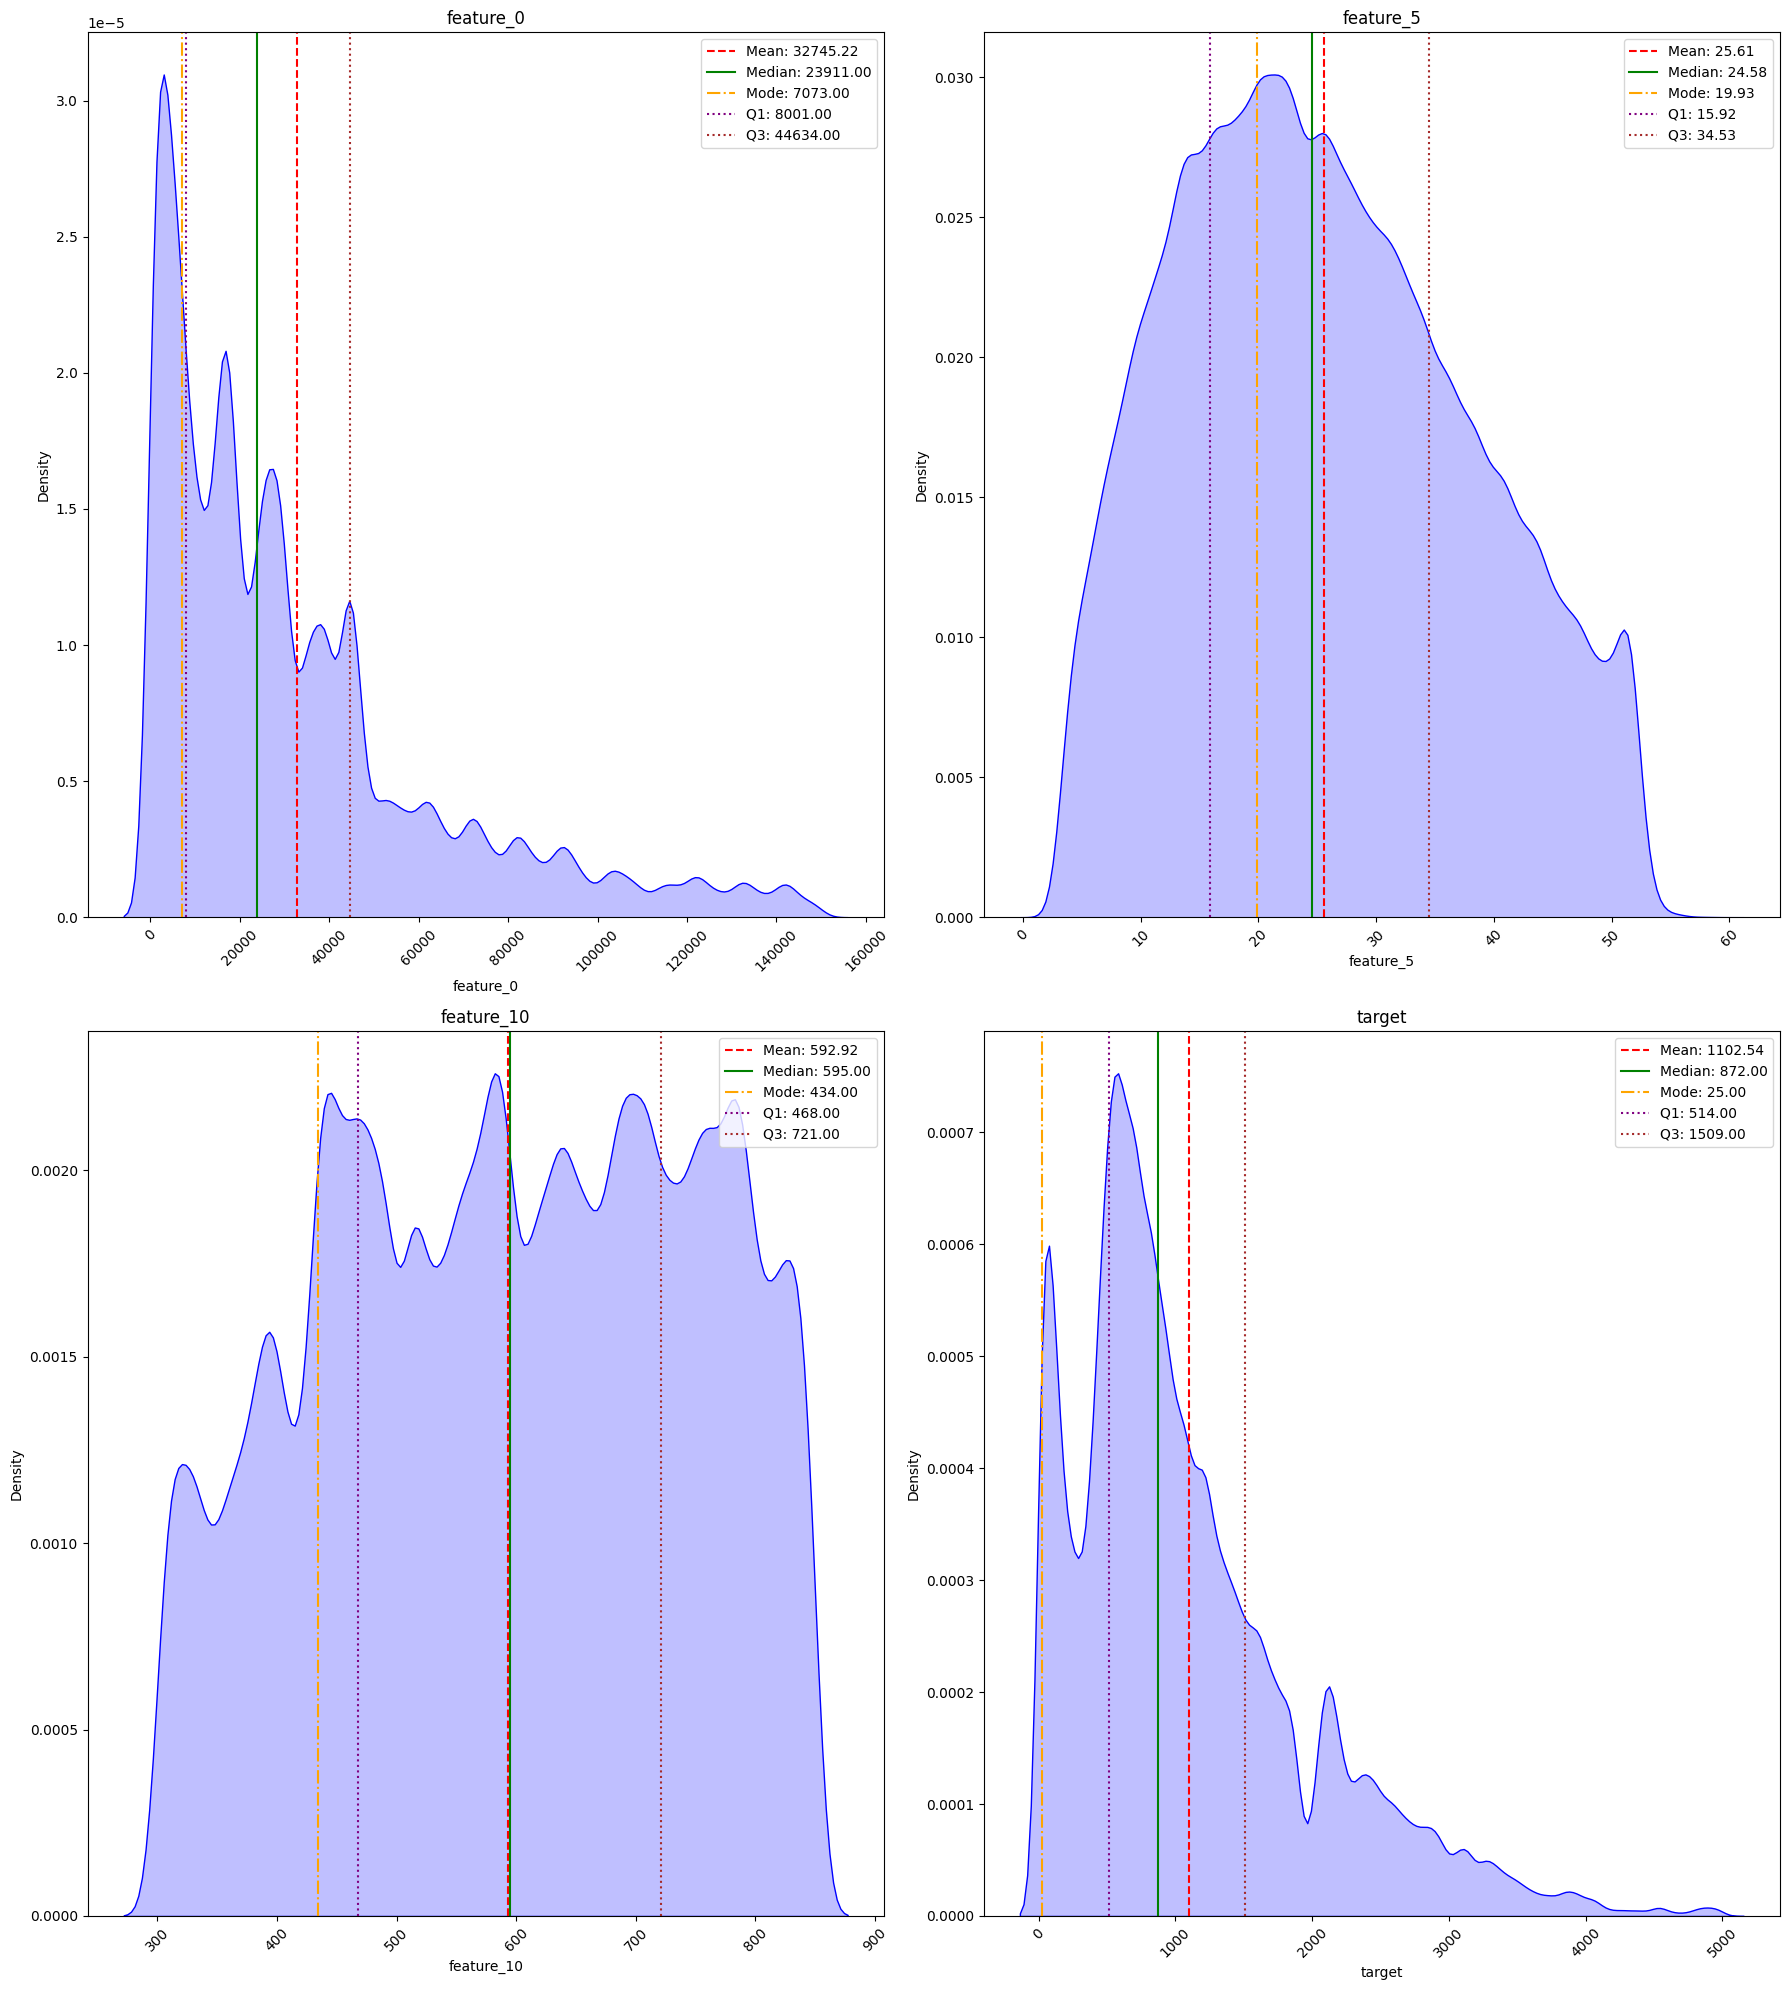

In [140]:
# KDE features
plt.figure(figsize=(18, 20))

for i, feature in enumerate(kde_features_num, 1):
    plt.subplot(2, 2, i)

    mean_val = train[feature].mean()
    median_val = train[feature].median()
    mode_val = train[feature].mode()[0]
    q1_val = train[feature].quantile(0.25)
    q3_val = train[feature].quantile(0.75)

    sns.kdeplot(train[feature], color="blue", fill=True)

    plt.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
    plt.axvline(median_val, color='green', linestyle='-', label=f"Median: {median_val:.2f}")
    plt.axvline(mode_val, color='orange', linestyle='-.', label=f"Mode: {mode_val:.2f}")
    plt.axvline(q1_val, color='purple', linestyle=':', label=f"Q1: {q1_val:.2f}")
    plt.axvline(q3_val, color='brown', linestyle=':', label=f"Q3: {q3_val:.2f}")

    plt.xticks(rotation=45)
    plt.ylabel("Density")
    plt.title(f"{feature}")
    plt.legend()

plt.tight_layout()
plt.show()

**Comments**

- *feature_0*, *target* - right-skewed distribution with a high density near zero. The long tail suggests the presence of outliers or extreme values

- *feature_5* - bell-shaped distribution with skew with a peak around 25-30. It has a slight right skew $\rightarrow$ a few higher values pull the mean to the right

- *feature_10* - irregular distribution when the density fluctuates with multiple peaks

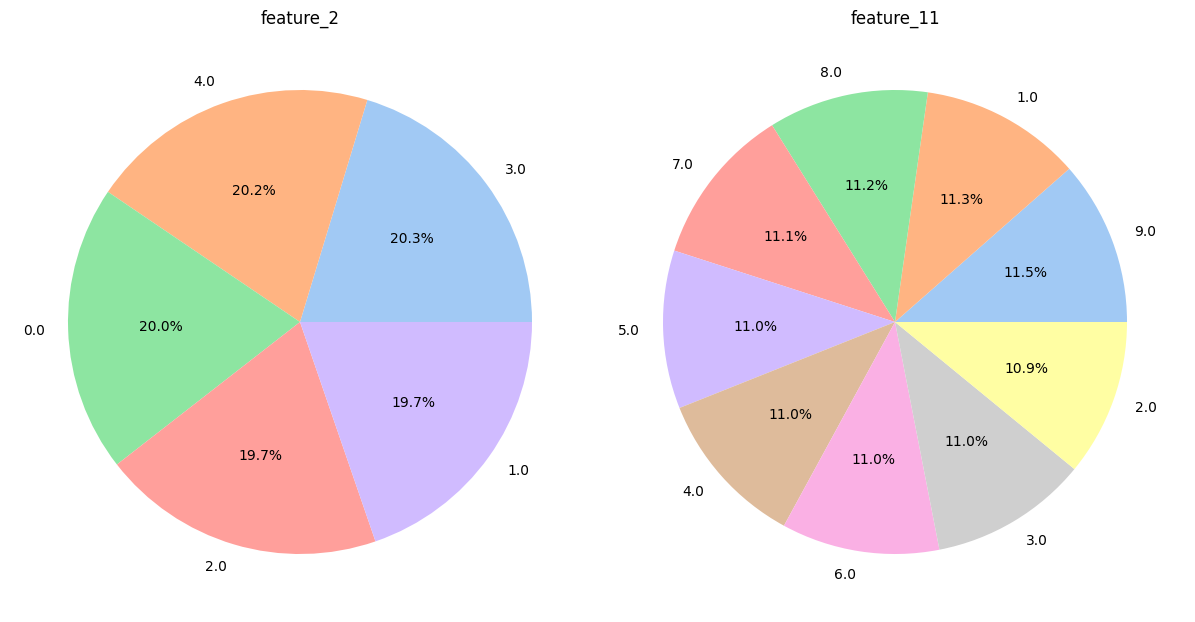

In [141]:
# Pie features
plt.figure(figsize=(18, 20))

for i, feature in enumerate(pie_features_num, 1):
    plt.subplot(3, 3, i + len(kde_features_num) + len(bar_features_num))
    value_counts = train[feature].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
    plt.title(f"{feature}")

plt.tight_layout()
plt.show()

**Comments**
- *feature_2* - the distribution is well-balanced with category holding around **19-20%**
- *feature_11* - the distribution is more fragmented with multiple values having similar percenteages (~11% each). The differences in percentages are small $\rightarrow$ this feature has many values with nearly equal representation

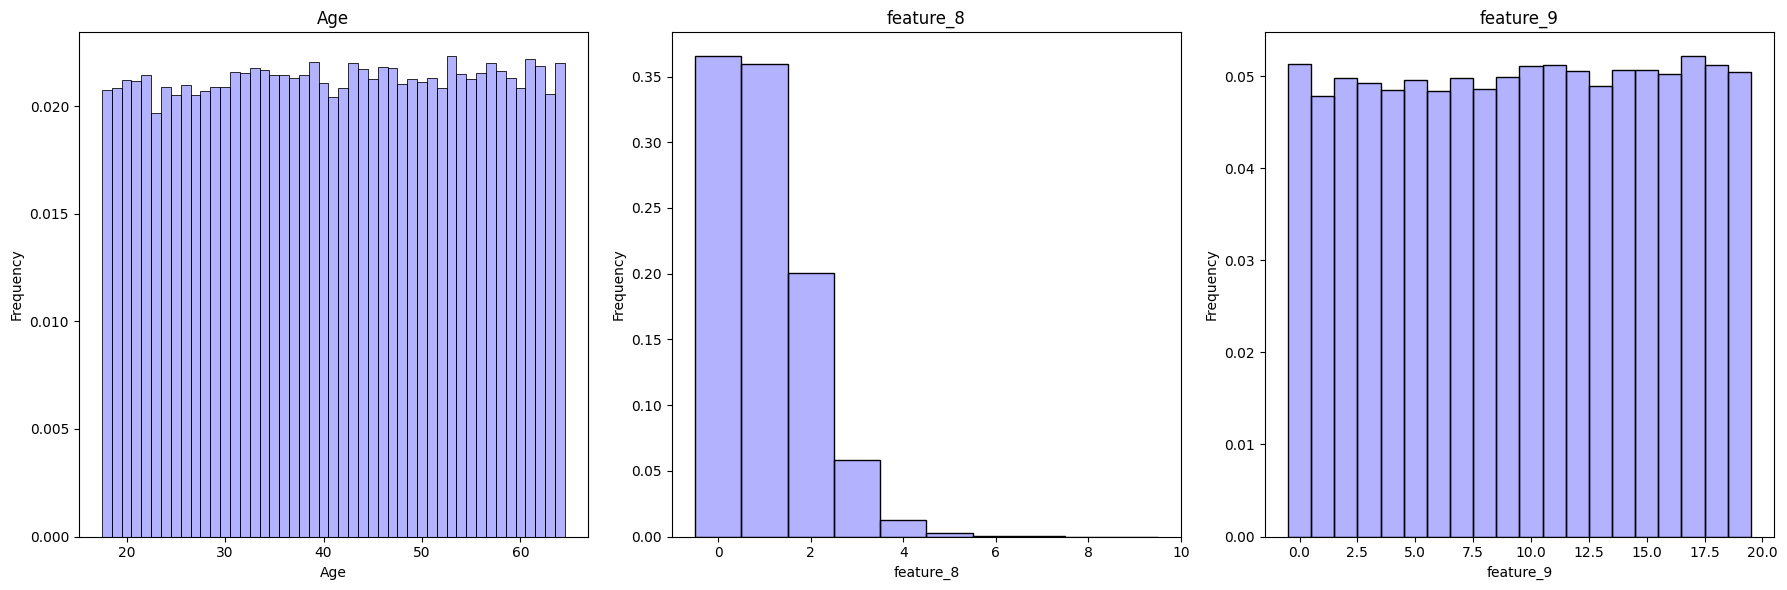

In [142]:
# Bar features
plt.figure(figsize=(18, 6))  

for i, feature in enumerate(bar_features_num, 1):
    plt.subplot(1, 3, i)  # 2 rows, 2 columns
    sns.histplot(train[feature], bins=5, color="blue", alpha=0.3, stat="density", discrete=True)
    plt.title(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Comments**
- *Age* - the distribution appears uniform (all age values occur with nearly the same frequency)
- *feature_8* - the distribution is highly right-skewed $\rightarrow$ most values are concentratd near zero with a long tail extending towards higher values
- *feature_9* - the distribution is nearly uniform - similar to the *Age* feature

**Categorical feature distributions**

In [143]:
pie_features_cat = ["Gender", "feature_1", "feature_3", "feature_4", "feature_6", "feature_7", "feature_13", "feature_14", "feature_15", "feature_16"]

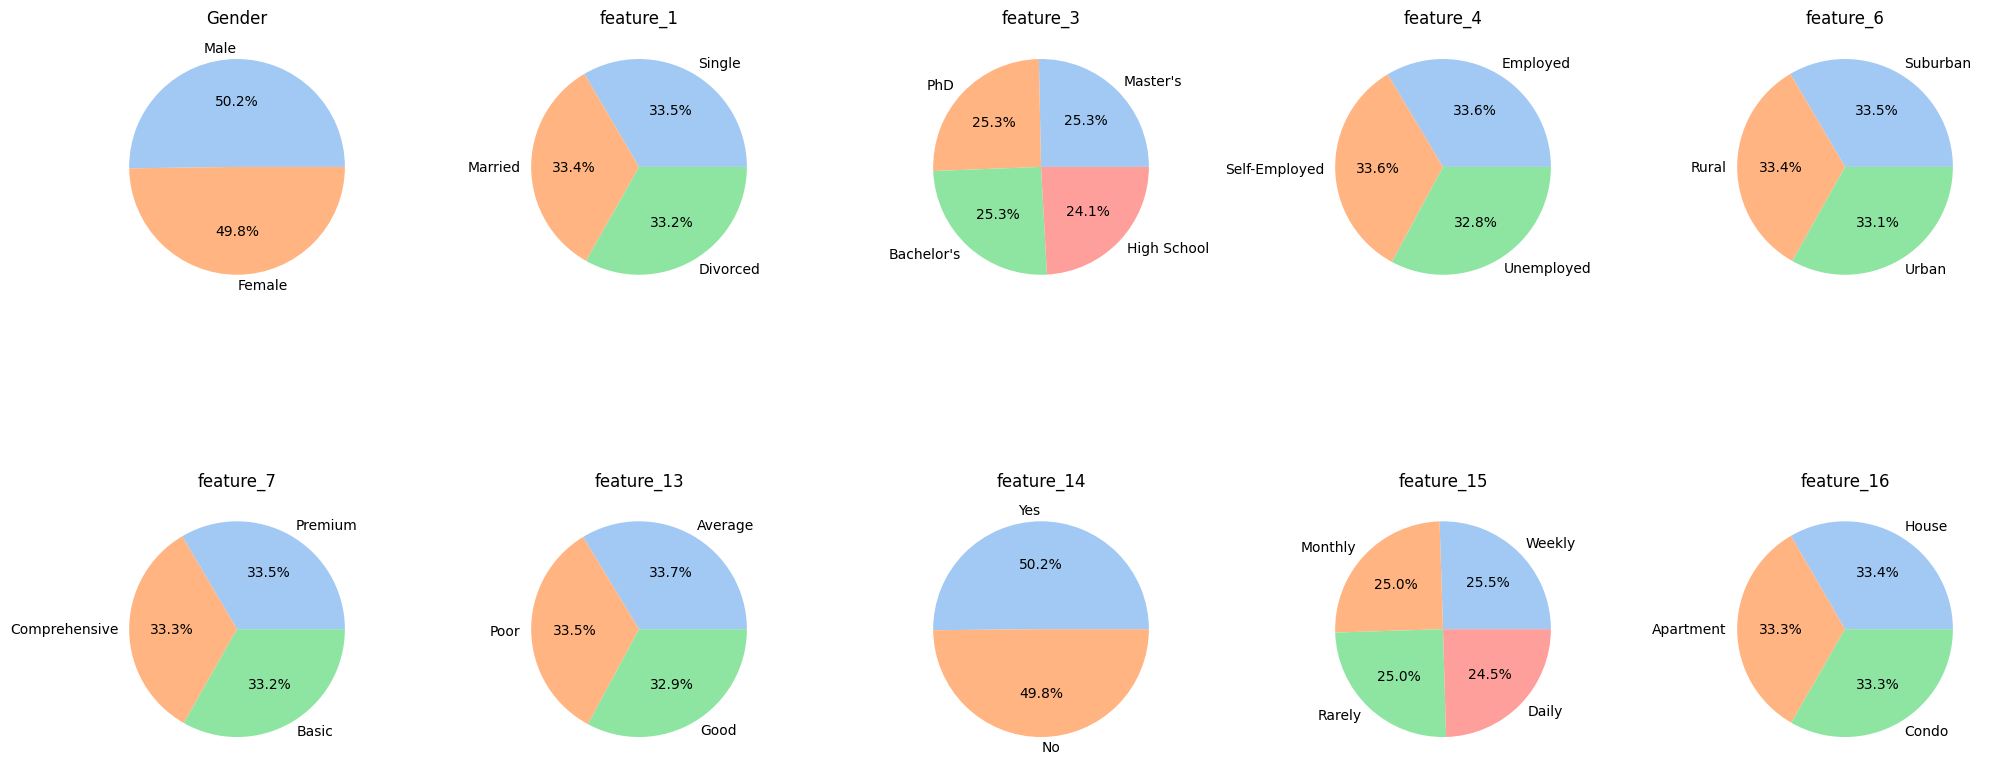

In [144]:
# Pie features
plt.figure(figsize=(20, 10))

for i, feature in enumerate(pie_features_cat, 1):
    plt.subplot(2, 5, i)
    value_counts = train[feature].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
    plt.title(feature)
    plt.ylabel("")

plt.tight_layout()
plt.show()

**Comments**

- All the features in these pie charts have an even distribution among their categories $\rightarrow$ unbiased modeling

- No feature appears to be skewed towards a particular category

**Skewed features**

In [145]:
def interpret_skew(skew_value):
    if abs(skew_value) < 0.5:
        return "Fairly symmetrical"
    elif 0.5 <= abs(skew_value) <= 1:
        return "Moderately skewed"
    else:
        return "Highly skewed"

In [146]:
skewness = {}
for feature in num_features:
    skew_value = skew(train[feature].dropna())  # dropna() handles any missing values
    skewness[feature] = round(skew_value, 3)

skew_train = pd.DataFrame(list(skewness.items()), columns=['Feature', 'Skewness'])

skew_train['Interpretation'] = skew_train['Skewness'].apply(interpret_skew)
print("\nWith Interpretation:")
print(skew_train)


With Interpretation:
      Feature  Skewness      Interpretation
0         Age    -0.013  Fairly symmetrical
1   feature_0     1.470       Highly skewed
2   feature_2    -0.013  Fairly symmetrical
3   feature_5     0.282  Fairly symmetrical
4   feature_8     0.905   Moderately skewed
5   feature_9    -0.020  Fairly symmetrical
6  feature_10    -0.114  Fairly symmetrical
7  feature_11    -0.009  Fairly symmetrical
8      target     1.241       Highly skewed


### **Data Cleaning**

#### **Remove irrelevant features**

The `id` feature does not contribute to the objective `target` because it is just the identification for each sample in the dataset.

The `feature_12` is the timestamp datatype, so the range value of this feature is very vast and each sample will have a nearly discrete timestamp $\rightarrow$ We speculate that this feature also does not contribute to the objective `target`.

$\Rightarrow$ Remove the `id` and `feature_12` out of the train and test file.

In [147]:
train = train.drop(columns=['feature_12', 'id'])
test = test.drop(columns=['feature_12', 'id'])

#### **Rename features**

In the **Exploratory of the dataset**, we realized that the objective `target` in the `train` dataset is the continuous values, whereas in the `test` dataset, the objective `target` is the nominal values such as House, Apartment, Condo,...and these values are similar to the `feature_16` in the `train` dataset. So, we decided to change the name of the `target` column to the `feature_16` in the `test` dataset.

In [148]:
test = test.rename(columns={'target': 'feature_16'})

#### **Handle missing values on train and test dataset**

**Features containing the missing values**

In [149]:
# Train dataset
missing_values = train.isnull().sum()
missing_features = missing_values[missing_values > 0]
missing_dtypes = train.dtypes[missing_features.index]

missing_summary = pd.DataFrame({"Missing Count": missing_features, "Data Type": missing_dtypes})

print(f"Features with Missing Values (total {len(missing_features)} features):")
print(missing_summary)

Features with Missing Values (total 11 features):
            Missing Count Data Type
Age                 18705   float64
feature_0           44949   float64
feature_1           18529    object
feature_2          109672   float64
feature_4          358075    object
feature_5           74076   float64
feature_8          364029   float64
feature_9               6   float64
feature_10         137882   float64
feature_11              1   float64
feature_13          77824    object


In [150]:
# Test dataset
missing_values = test.isnull().sum()
missing_features = missing_values[missing_values > 0]
missing_dtypes = test.dtypes[missing_features.index]

missing_summary = pd.DataFrame({"Missing Count": missing_features, "Data Type": missing_dtypes})

print(f"Features with Missing Values (total {len(missing_features)} features):")
print(missing_summary)

Features with Missing Values (total 11 features):
            Missing Count Data Type
Age                 12489   float64
feature_0           29860   float64
feature_1           12336    object
feature_2           73130   float64
feature_4          239125    object
feature_5           49449   float64
feature_8          242802   float64
feature_9               3   float64
feature_10          91451   float64
feature_11              2   float64
feature_13          52276    object


**Handle missing values of *feature_0*, *feature_5, *feature_10****

As the KDE plot the distribution of `feature_0`, `feature_5` and `feature_10` plotted above, we realize that each has a different distribution type (The right-skewed distribution of `feature_0`, the nearly bell-shaped one of `feature_5`, and the multiple peaks one of `feature_10`).

**Solution**: We fill the missing value in each feature by **random sampling** between $Q_1$ and $Q_3$ to maintain variability.

In [151]:
for i, feature in enumerate(["feature_0", "feature_5", "feature_10"]):
    missing_count = train[feature].isna().sum()
    q1_val = train[feature].quantile(0.25)
    q3_val = train[feature].quantile(0.75)
    train.loc[train[feature].isna(), feature] = np.random.uniform(q1_val, q3_val, missing_count)

In [152]:
for i, feature in enumerate(["feature_0", "feature_5", "feature_10"]):
    missing_count = test[feature].isna().sum()
    q1_val = test[feature].quantile(0.25)
    q3_val = test[feature].quantile(0.75)
    test.loc[test[feature].isna(), feature] = np.random.uniform(q1_val, q3_val, missing_count)

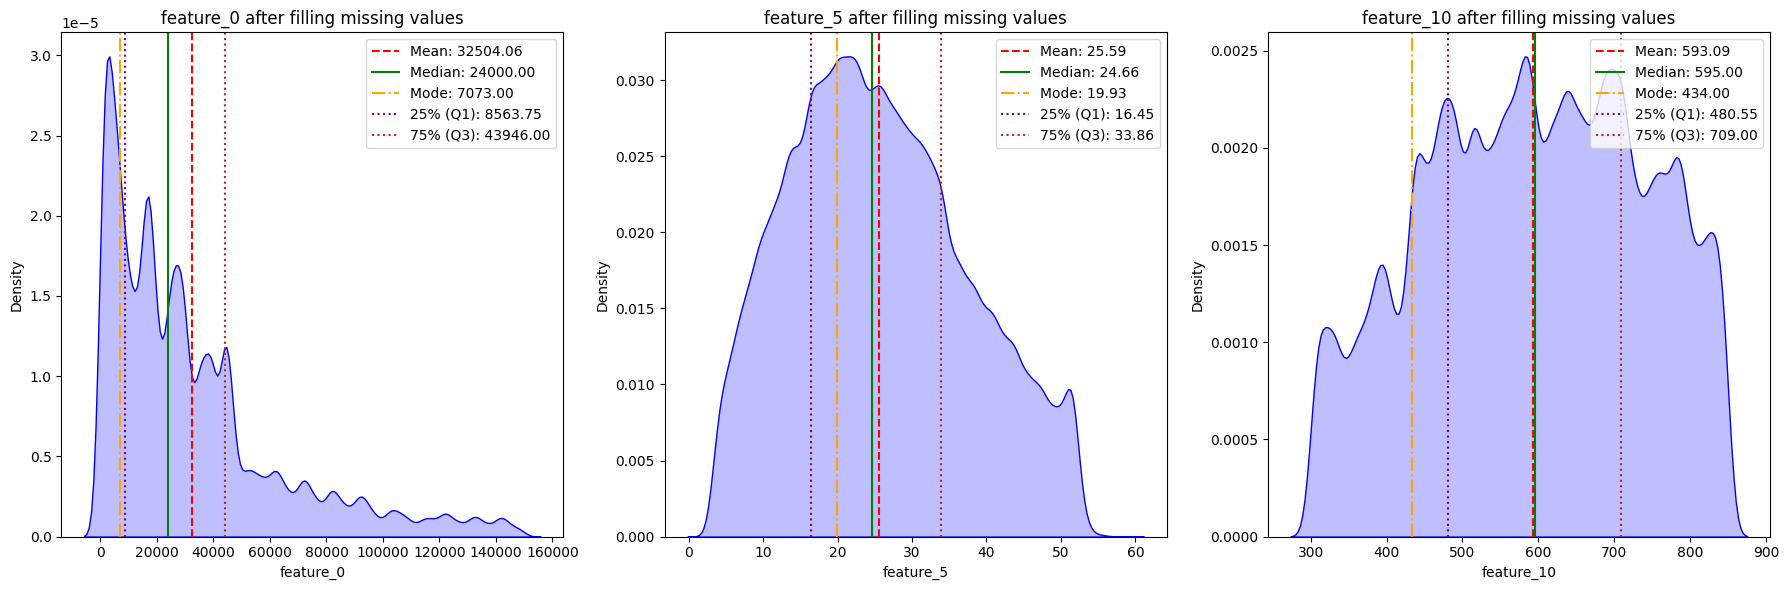

In [153]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature in enumerate(["feature_0", "feature_5", "feature_10"]):
    mean_val = train[feature].mean()
    median_val = train[feature].median()
    mode_val = train[feature].mode()[0]
    q1_val = train[feature].quantile(0.25)
    q3_val = train[feature].quantile(0.75)

    sns.kdeplot(train[feature], color="blue", fill=True, ax=axes[i])

    axes[i].axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
    axes[i].axvline(median_val, color='green', linestyle='-', label=f"Median: {median_val:.2f}")
    axes[i].axvline(mode_val, color='orange', linestyle='-.', label=f"Mode: {mode_val:.2f}")
    axes[i].axvline(q1_val, color='purple', linestyle=':', label=f"25% (Q1): {q1_val:.2f}")
    axes[i].axvline(q3_val, color='brown', linestyle=':', label=f"75% (Q3): {q3_val:.2f}")

    axes[i].set_title(f"{feature} after filling missing values")
    axes[i].legend()

plt.tight_layout()
plt.show()

$\Rightarrow$ We fill the missing value in *feature_0*, *feature_5* and *feature_10* by random sampling between Q1 and Q3 to maintain variability. The difference between *mean*, *median*, *mode*, *Q1* and *Q3* before and after filling the missing values does not change much.

Note: Because of the skewness of the *feature_0* distribution, filling with the median is a good choice (Median is not affected by outliers) $\rightarrow$ Try later

**Handle missing values of *feature_1*, *feature_2*, *feature_4*, *feature_11* and *feature_13***

As the pie chart plots the distribution of `feature_1`, `feature_2`, `feature_4`, `feature_11`, and `feature_13`, we realize that each value in the features accounts for nearly the same percentage.

Let’s consider the `feature_1`, it has 3 distinct values including **Married**, **Single** and **Divorced** and each of them accounts for nearly $\frac{1}{3} = 33.3\%$ or consider the `feature_2`, it has 5 distinct values
including **0.0**, **1.0**, **2.0**, **3.0** and **4.0** and each of them also accounts for nearly $\frac{1}{5} = 20\%$. All of these features have the same distribution ‘rule‘.

**Solution**: Firstly, we compute the value distribution of each value of the features, then we fill missing values using random sampling.

In [154]:
# Train dataset
for feature in ["feature_1", "feature_2", "feature_4", "feature_11", "feature_13"]:
    missing_count = train[feature].isna().sum()
    value_counts = train[feature].value_counts(normalize=True)

    train.loc[train[feature].isna(), feature] = np.random.choice(value_counts.index, size=missing_count, p=value_counts.values)

In [155]:
# Test dataset
for feature in ["feature_1", "feature_2", "feature_4", "feature_11", "feature_13"]:
    missing_count = test[feature].isna().sum()
    value_counts = test[feature].value_counts(normalize=True)

    test.loc[test[feature].isna(), feature] = np.random.choice(value_counts.index, size=missing_count, p=value_counts.values)

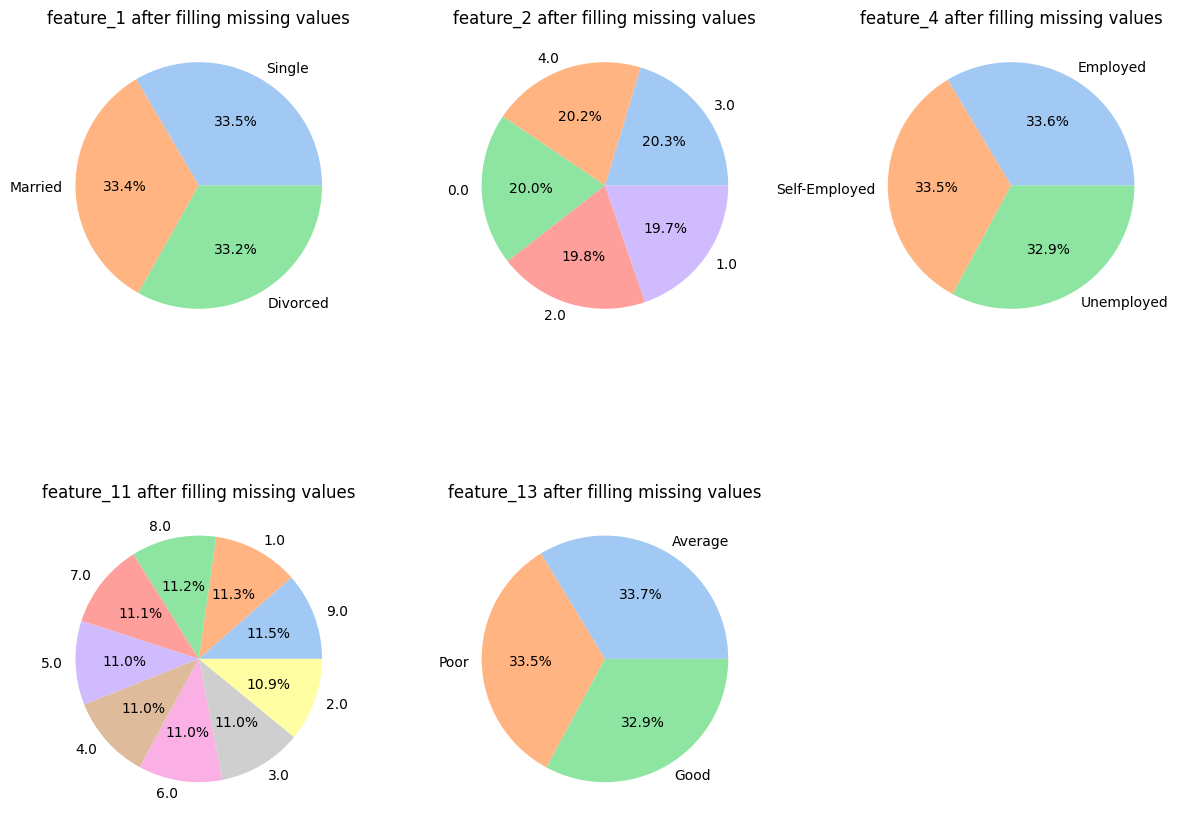

In [156]:
plt.figure(figsize=(12, 10))

for i, feature in enumerate(["feature_1", "feature_2", "feature_4", "feature_11", "feature_13"], 1):
    plt.subplot(2, 3, i)
    value_counts = train[feature].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
    plt.title(f"{feature} after filling missing values")

plt.tight_layout()
plt.show()

$\Rightarrow$ The percentage of each value of the features before and after filling the missing values does not change much.

**Handle missing values of *feature_8***

The `feature_8` is discrete and has a right-skewed distribution, so we can not fill missing values by using a random choice $\rightarrow$ maybe fill/create more outliers when almost values concentrate at the left.

**Solution**: We fill the missing value in each feature by random sampling between $Q_1$ and $Q_3$ to maintain variability or using median. 

Note: The resulting distribution was written in the report.

In [157]:
# Train dataset
missing_count = train['feature_8'].isna().sum()
q1_val = train['feature_8'].quantile(0.25)
q3_val = train['feature_8'].quantile(0.75)
train.loc[train['feature_8'].isna(), 'feature_8'] = np.random.uniform(q1_val, q3_val, missing_count)

median_val = train['feature_8'].median()

In [158]:
# Test dataset
missing_count = test['feature_8'].isna().sum()
q1_val = test['feature_8'].quantile(0.25)
q3_val = test['feature_8'].quantile(0.75)
test.loc[test['feature_8'].isna(), 'feature_8'] = np.random.uniform(q1_val, q3_val, missing_count)

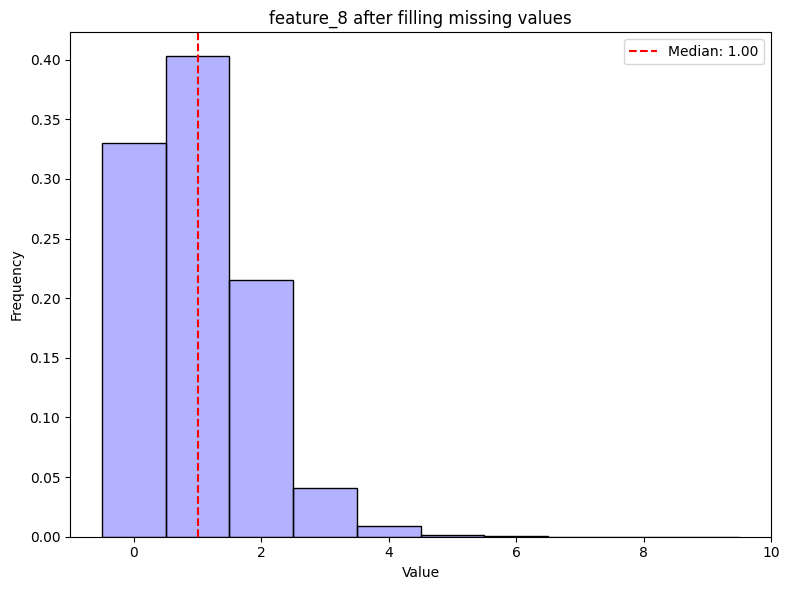

In [159]:
# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(train['feature_8'], bins=5, color="blue", alpha=0.3, stat="density", discrete=True)

# Add vertical line for the median
plt.axvline(median_val, color='red', linestyle='--', label=f"Median: {median_val:.2f}")

plt.title("feature_8 after filling missing values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

$\Rightarrow$ The distribution of `feature_8` after filling missing values by random sampling between $Q_1$ and $Q_3$ is quite the same as before preprocessing, so we choose to fill missing values by **random sampling**

**Handle missing values of *Age* and *feature_9***

As the bar chart plots the distribution of `Age` and `feature_9`, we realize that both distributions appear quite uniform, meaning each value occurs with nearly the same frequency. The small variations in bar heights indicate that there are some fluctuations, but they are not significant.

**Solution**: Randomly select only the non-missing values of that feature with replacement.

In [160]:
for feature in ["feature_9", "Age"]:
    missing_count = train[feature].isna().sum()
    train.loc[train[feature].isna(), feature] = np.random.choice(train[feature].dropna(), size=missing_count, replace=True)
    # 6
    missing_count = test[feature].isna().sum()
    test.loc[test[feature].isna(), feature] = np.random.choice(test[feature].dropna(), size=missing_count, replace=True)

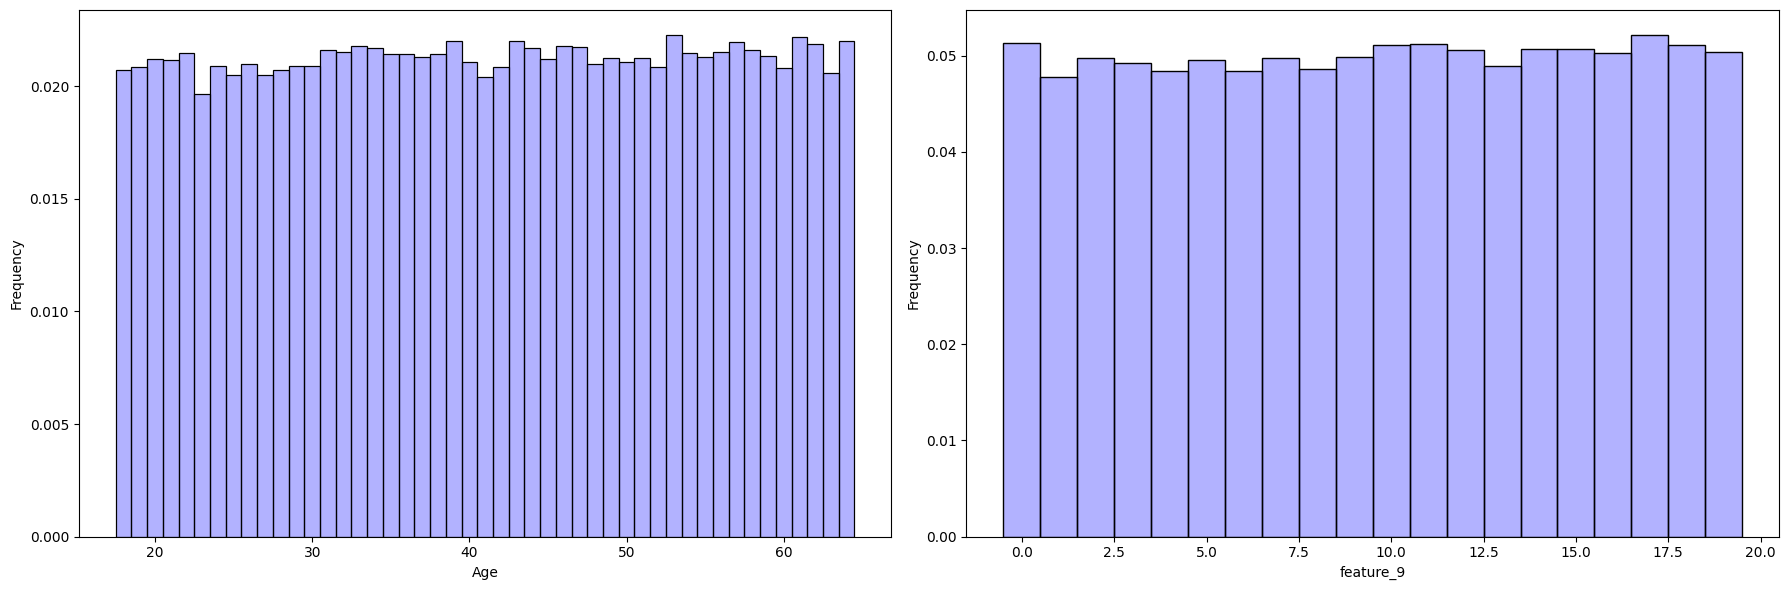

In [161]:
plt.figure(figsize=(18, 6))

for i, feature in enumerate(["Age", "feature_9"]):
    plt.subplot(1, 2, i+1)
    sns.histplot(train[feature], bins=5, color="blue", alpha=0.3, stat="density", discrete=True)
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

$\Rightarrow$ The distribution of `Age` and `feature_9` after filling missing values by random sampling is quite the same as before preprocessing or maintains the variability.

**Validate that all missing values have been filled**

In [162]:
# Train dataset
missing_values = train.isnull().sum()
missing_features = missing_values[missing_values > 0]
missing_dtypes = train.dtypes[missing_features.index]

missing_summary = pd.DataFrame({"Missing Count": missing_features, "Data Type": missing_dtypes})

print(f"Features with Missing Values on train dataset (total {len(missing_features)} features):")
print(missing_summary)

Features with Missing Values on train dataset (total 0 features):
Empty DataFrame
Columns: [Missing Count, Data Type]
Index: []


In [163]:
# Test dataset
missing_values = test.isnull().sum()
missing_features = missing_values[missing_values > 0]
missing_dtypes = test.dtypes[missing_features.index]

missing_summary = pd.DataFrame({"Missing Count": missing_features, "Data Type": missing_dtypes})

print(f"Features with Missing Values on test dataset (total {len(missing_features)} features):")
print(missing_summary)

Features with Missing Values on test dataset (total 0 features):
Empty DataFrame
Columns: [Missing Count, Data Type]
Index: []


#### **Handle Duplicates**

After filling in the missing values, we checked the train dataset and found that it likely contains some duplicates since the missing values were filled randomly, so we decided to drop the duplicates.

In [164]:
num_duplicates = train.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1


In [165]:
train.drop_duplicates(inplace=True)

### **Feature Engineering**

*Extract* or *construct* new features as you need to *augment the newly obtained data* or to *mitigate problems from prior phase(s)*.

#### **Label encoding for ordinal features**

With the `feature_3`, `feature_7`, `feature_13`, and `feature_15`, the order relationship between each value of features is represented in the table below

In [166]:
ordinal_mappings = {
    "feature_3": {"PhD": 1, "Master's": 2, "Bachelor's": 3, "High School": 4},
    "feature_7": {"Premium": 1, "Comprehensive": 2, "Basic": 3},
    "feature_13": {"Good": 1, "Average": 2, "Poor": 3},
    "feature_15": {"Daily": 1, "Weekly": 2, "Monthly": 3, "Rarely": 4}
}

for feature, mapping in ordinal_mappings.items():
    train[feature] = train[feature].map(mapping)
    test[feature] = test[feature].map(mapping)

#### **One-Hot Encoding for nominal feature**

In [167]:
nominal_features = ["feature_1", "feature_4", "feature_6","feature_16"]

train = pd.get_dummies(train, columns=nominal_features, drop_first=True)
train["Gender"] = train["Gender"].map({"Male": 1, "Female": 0})
train["feature_14"] = train["feature_14"].map({"Yes": 1, "No": 0})

test = pd.get_dummies(test, columns=nominal_features, drop_first=True)
test["Gender"] = test["Gender"].map({"Male": 1, "Female": 0})
test["feature_14"] = test["feature_14"].map({"Yes": 1, "No": 0})

#### **Feature Transformation**

In [168]:
train_trans, test_trans = copy.deepcopy(train), copy.deepcopy(test)

**Min-Max Scaling (Normalization)** 

To ensure that the numerical features are on the same scale and to improve model performance, we apply **Min-Max Scaling (Normalization)** to the features `Age`, `feature_2`, `feature_8`, `feature_9`,and `feature_11`. These features have clear minimum and maximum bounds, making them suitable for normalization.

**Solution**: Use the `MinMaxScaler` to scale each value to the range [0, 1]. The transformation is applied separately to both the train and test datasets to prevent data leakage.

In [169]:
scaler = MinMaxScaler()
train_trans[["Age", "feature_2", "feature_8", "feature_9", "feature_11"]] = scaler.fit_transform(train_trans[["Age", "feature_2", "feature_8", "feature_9", "feature_11"]])
test_trans[["Age", "feature_2", "feature_8", "feature_9", "feature_11"]] = scaler.transform(test_trans[["Age", "feature_2", "feature_8", "feature_9", "feature_11"]])

**Standardization (Z-score Normalization)**

For the feature `feature_10`, we apply **Standardization (Z-score Normalization)** since it contains large numerical values with a different scale compared to other features. Standardization rescales the feature to have a mean of 0 and a standard deviation of 1, which helps many machine learning models converge faster and perform better.

**Solution**: Use the `StandardScaler` to transform `feature_10`. The scaler is fitted on the training data and then applied to the test data to avoid data leakage.

In [170]:
scaler = StandardScaler()
train_trans[["feature_10"]] = scaler.fit_transform(train_trans[["feature_10"]])
test_trans[["feature_10"]] = scaler.transform(test_trans[["feature_10"]])

**Robust Scaling (For Outliers)**

For the features `feature_0` and `feature_5`, we apply **Robust Scaling** because these features have high variance and may contain outliers. Robust scaling uses the median and the interquartile range (IQR) to rescale the data, which makes it less sensitive to outliers compared to other scaling methods like MinMax scaling or Standardization. This ensures that the model does not give undue weight to extreme values.

**Solution**: Use the `RobustScaler` to transform `feature_0` and `feature_5`. The scaler is fitted on the training data and then applied to the test data to prevent data leakage.

In [171]:
scaler = RobustScaler()
train_trans[["feature_0", "feature_5"]] = scaler.fit_transform(train_trans[["feature_0", "feature_5"]])
test_trans[["feature_0", "feature_5"]] = scaler.transform(test_trans[["feature_0", "feature_5"]])

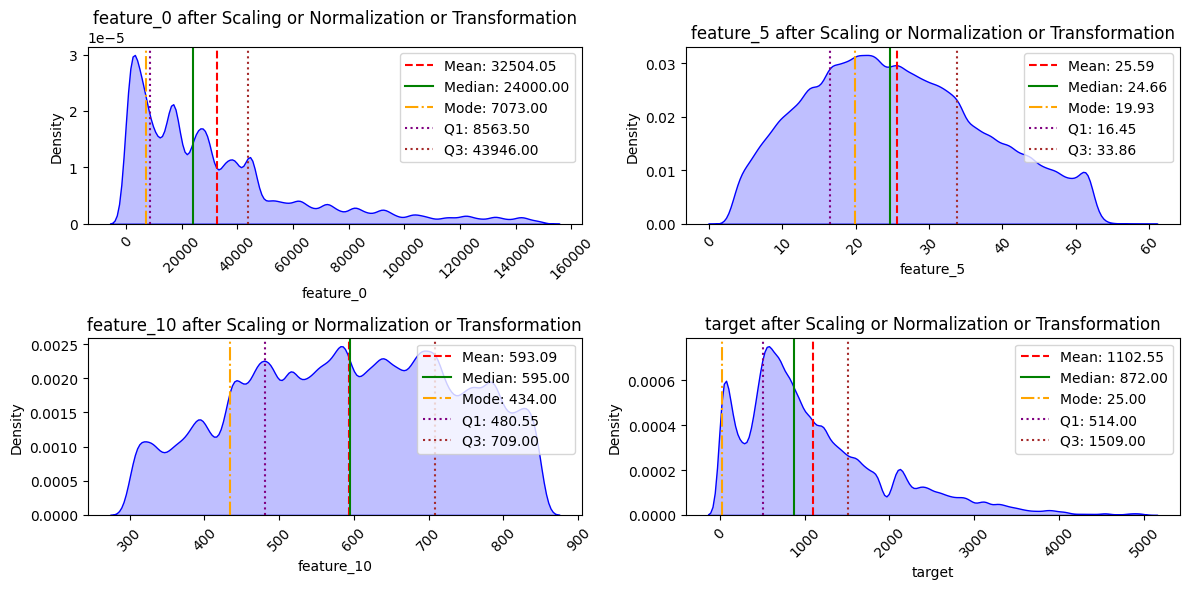

In [172]:
# KDE features
plt.figure(figsize=(12, 6))

for i, feature in enumerate(kde_features_num, 1):
    plt.subplot(2, 2, i)

    mean_val = train[feature].mean()
    median_val = train[feature].median()
    mode_val = train[feature].mode()[0]
    q1_val = train[feature].quantile(0.25)
    q3_val = train[feature].quantile(0.75)

    sns.kdeplot(train[feature], color="blue", fill=True)

    plt.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
    plt.axvline(median_val, color='green', linestyle='-', label=f"Median: {median_val:.2f}")
    plt.axvline(mode_val, color='orange', linestyle='-.', label=f"Mode: {mode_val:.2f}")
    plt.axvline(q1_val, color='purple', linestyle=':', label=f"Q1: {q1_val:.2f}")
    plt.axvline(q3_val, color='brown', linestyle=':', label=f"Q3: {q3_val:.2f}")

    plt.xticks(rotation=45)
    plt.ylabel("Density")
    plt.title(f"{feature} after Scaling or Normalization or Transformation")
    plt.legend()

plt.tight_layout()
plt.show()

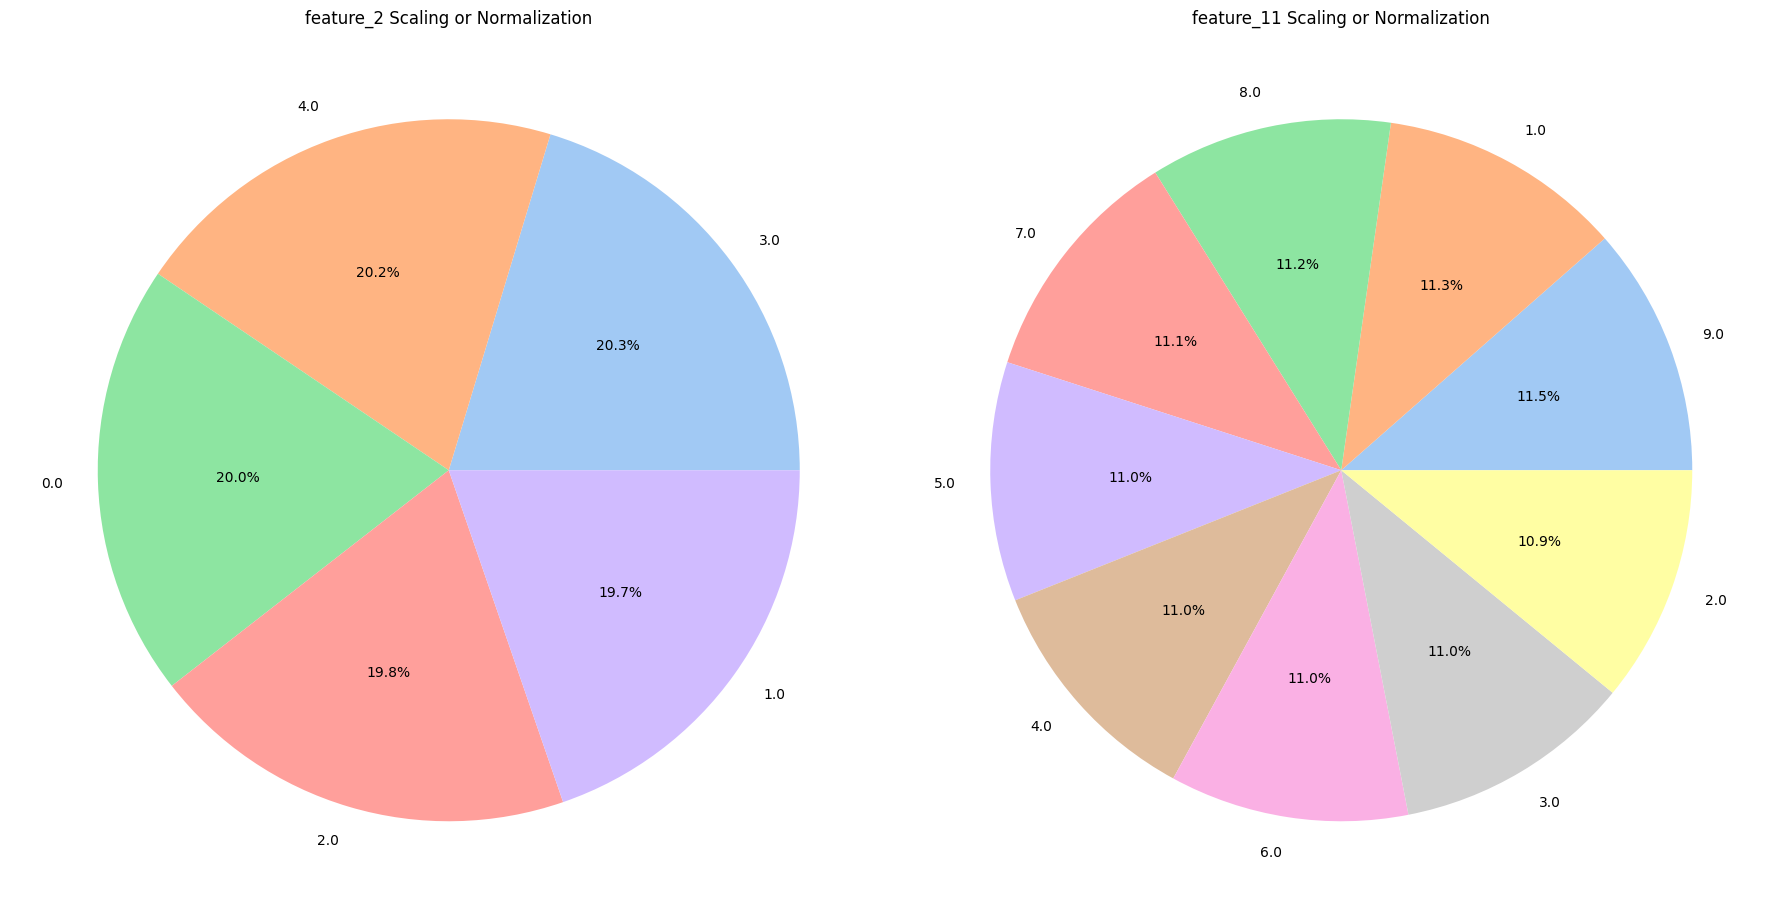

In [173]:
# Pie features
plt.figure(figsize=(18, 20))

for i, feature in enumerate(pie_features_num, 1):
    plt.subplot(1, 2, i)
    value_counts = train[feature].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
    plt.title(f"{feature} Scaling or Normalization")

plt.tight_layout()
plt.show()

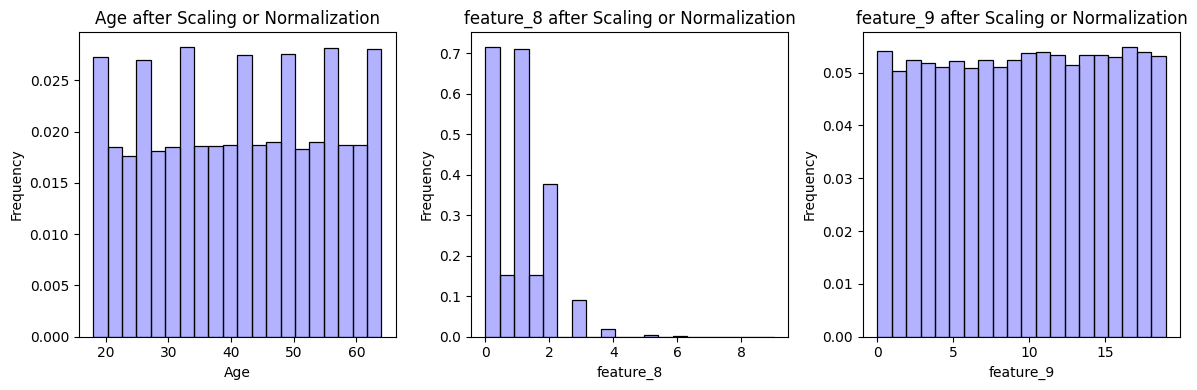

In [174]:
# Bar features
plt.figure(figsize=(12, 4))

for i, feature in enumerate(bar_features_num, 1):
    plt.subplot(1, 3, i)
    sns.histplot(train[feature], bins=20, color="blue", alpha=0.3, stat="density")
    plt.ylabel("Frequency")
    plt.title(f"{feature} after Scaling or Normalization")

plt.tight_layout()
plt.show()

#### **Feature Engineering**

In [175]:
# Define features
numerical_features = ['Age', 'feature_0', 'feature_2', 'feature_3', 'feature_5', 
                      'feature_7', 'feature_8', 'feature_9', 'feature_10', 
                      'feature_11', 'feature_13', 'feature_15']
categorical_features = ['Gender', 'feature_14', 'feature_1_Married', 'feature_1_Single', 
                        'feature_4_Self-Employed', 'feature_4_Unemployed', 
                        'feature_6_Suburban', 'feature_6_Urban', 
                        'feature_16_Condo', 'feature_16_House']

In [176]:
# Initialize transformers
scaler = StandardScaler()
kmeans = KMeans(n_clusters=5, random_state=42)

# Feature engineering with reduced features
def create_features(df, is_train=True, scaler=None, kmeans=None):
    df_index = df.index
    df = df.copy()

    X_scaled = pd.DataFrame(
        scaler.fit_transform(df[numerical_features]) if is_train else scaler.transform(df[numerical_features]),
        columns=[f'{f}_scaled' for f in numerical_features],
        index=df_index
    )

    X_manual = pd.DataFrame(index=df_index)
    for f in numerical_features:
        scaled_col = f'{f}_scaled'
        x = X_scaled[scaled_col]
        x_norm = 2 * np.pi * (x - x.min()) / (x.max() - x.min() + 1e-6)
        X_manual[f'{f}_sin'] = np.sin(x_norm)
        X_manual[f'{f}_cos'] = np.cos(x_norm)
        X_manual[f'{f}_tan'] = np.tan(x_norm).clip(-1e6, 1e6)
        X_manual[f'{f}_cot'] = 1 / np.tan(x_norm + 1e-6).clip(-1e6, 1e6)
        X_manual[f'{f}_sinh'] = np.sinh(x)
        X_manual[f'{f}_cosh'] = np.cosh(x)
        X_manual[f'{f}_tanh'] = np.tanh(x)
        X_manual[f'{f}_sigmoid'] = expit(x)

    top_num_features = ['Age', 'feature_0', 'feature_5', 'feature_8', 'feature_15']
    X_arithmetic = pd.DataFrame(index=df_index)
    for i, f1 in enumerate(top_num_features):
        for f2 in top_num_features[i+1:]:
            x1, x2 = df[f1], df[f2]
            X_arithmetic[f'{f1}_plus_{f2}'] = x1 + x2
            X_arithmetic[f'{f1}_minus_{f2}'] = x1 - x2
            X_arithmetic[f'{f1}_times_{f2}'] = x1 * x2
            X_arithmetic[f'{f1}_div_{f2}'] = x1 / (x2 + 1e-6)


    X_cluster = pd.DataFrame(index=df_index)
    cluster_labels = kmeans.fit_predict(X_scaled) if is_train else kmeans.predict(X_scaled)
    X_cluster['cluster_label'] = cluster_labels

    X_cat = df[categorical_features]

    X_engineered = pd.concat([
        X_scaled, X_manual, X_arithmetic, X_cluster, X_cat
    ], axis=1)
    X_engineered = X_engineered.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

    return X_engineered

### **Model Development**

This is when you develops models to *capture the patterns revealed during the analysis*. This step involves *selecting appropriate modeling approach* and *design a detailed algorithm*.

<p style="font-size:40px; font-weight:bold;">Phase 1: Scikit-learn</p>

<p style="font-size:40px; font-weight:bold;">Decision Tree</p>

**Why choose a Decision Tree?**

**Decision Tree** is a versatile and interpretable machine learning model and several aspects of the dataset and problem make it a reasonable choice

About the dataset:
- **The mix of a numerical (discrete, continuous, ordinal) and categorical (nominal, ordinal) features** and Decision Trees can handle both types without requiring extensive preprocessing like normalization or standardization for categorical (once encoded) or numerical features

- **The presence of non-linear relationship or complex interactions between features and target**, Decision Trees are good at capturing non-linear patterns and interactions without explicitly modelling of these relationships

- **The skewness analysis** above showed features like `feature_0` (1.470) and `target` (1.241) are highly skewed and `feature_8` (0..905) is moderately skewed $\rightarrow$ Decision Trees are robust to skewed distribution and outliers because they use threshold-based splits rather than distance-based metrics

- Decision Trees can handle high-dimensional data and automatically perform feature selection by choosing the most informative splits when engineering the new feature set (polynomial features, binned features, etc.)

About the nature of the model:
- Decision Trees provide clear decision rules, for example, if `Age` > 30 and `feature_0` < ... then predict X, which can be valuable for understanding how features contribute to the target $\rightarrow$ useful for explaining the model to stakeholders or debugging its predictions
- Decision Trees are often used as a strong baseline model due to their simplicity and ability to capture complex patterns

About the problem:

- Have to say that, the target variable `target` in the training dataset is continuous so this is the regression problem $\rightarrow$ Decision Trees can predict continuous outcomes by averaging the target values in each leaf node

**Architecture Design**

**The initial hyperparameters setup**

- `splitter='best'` (chooses the best split at each node $\rightarrow$ maximize information gain)
- `max_depth=10` (limits tree depth to prevent overfitting and to allow sufficient complexity to capture patterns)
- `min_samples_split=10` (requires at least 10 samples to split a node $\rightarrow$ reduce noise-driven splits)
- `min_samples_leaf=5` (requires each leaf to have at least 5 samples $\rightarrow$ improve generalization)
- `max_leaf_nodes=5` (caps the number of leaves $\rightarrow$ control overfitting )
- `min_weight_fraction_leaf=0.0` (treating all samples equally)
- `max_features=None` (considers all features for each split)
- `min_impurity_decrease=0.0` (no minimum impurity reduction required for splits)
- `ccp_alpha=0.0` (no pruning $\rightarrow$ full growth)

**The hyperparameters tuning setup for Bayesian Optimization**

*See in below*


**Training setup**

1. **Data Split**:
   - Using a large train + validation set (85%) for cross-validation and tuning while a test set for final evaluation (15%) $\rightarrow$ kinda sufficient data for training on a complex feature set while holding out an unbiased test set

2. **Cross-Validation**:
   - 5-fold cross-validation with shuffling (`random_state=42`) for robust performance estimates and balancing bias-variance trade-off and ensures generalization

3. **Evaluation Metrics**:
   - Use **RMSLE** as the primary metric, computed using `mean_squared_log_error` from scikit-learn
   - Standard deviations (`+/- 2*std`) provide confidence intervals for cross-validation results

4. **Hyperparameter Tuning**:
   - Bayesian optimization planned to efficiently search for optimal hyperparameters minimizing RMSLE

5. **Training Process**
    - Fits the model on training folds, predicts on both training and validation folds, and aggregates results to assess overfitting (train vs. validation performance) and ensures stable performance estimates

**Split the dataset**

Train the model with the non-transformation (normalization/scaling/standardization) traning dataset

Split the data into train + validation (85%) and test (15%)



In [48]:
# Separate features and target from training data
X_dt = train.drop('target', axis=1)  # Features
y_dt = train['target']              # Target

# Train-70, Valid-15, Test-15
X_train_val_dt, X_test_dt, y_train_val_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.15, random_state=42)

print(f"Training set size: {X_train_val_dt.shape[0]} samples")
print(f"Test set size: {X_test_dt.shape[0]} samples")

Training set size: 1019999 samples
Test set size: 180000 samples


In [50]:
def evaluate_model(pipeline, X_train_val, y_train_val, X_test, y_test, criterion='squared_error'):    
    pipeline.named_steps['regressor'].set_params(criterion=criterion)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = []
    
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X_train_val, y_train_val)):
        print(f"  Training fold {fold + 1}/5...")
        
        X_train_fold, y_train_fold, X_valid_fold, y_valid_fold = X_train_val.iloc[train_idx], y_train_val.iloc[train_idx], X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx]        
        pipeline.fit(X_train_fold, y_train_fold)
        
        y_pred_train_fold, y_pred_valid_fold = pipeline.predict(X_train_fold), pipeline.predict(X_valid_fold)
 
        train_rmsle = np.sqrt(mean_squared_log_error(np.clip(y_train_fold, 0, None), np.clip(y_pred_train_fold, 0, None)))
        valid_rmsle = np.sqrt(mean_squared_log_error(np.clip(y_valid_fold, 0, None), np.clip(y_pred_valid_fold, 0, None)))
        
        cv_results.append({
            'train_rmsle': train_rmsle,
            'valid_rmsle': valid_rmsle
        })
    
    result = {
        'train_rmsle': np.mean([r['train_rmsle'] for r in cv_results]),
        'valid_rmsle': np.mean([r['valid_rmsle'] for r in cv_results]),
        'train_rmsle_std': np.std([r['train_rmsle'] for r in cv_results]) * 2,
        'valid_rmsle_std': np.std([r['valid_rmsle'] for r in cv_results]) * 2
    }
    
    pipeline.fit(X_train_val, y_train_val)
    y_pred_test = pipeline.predict(X_test)
    result['test_rmsle'] = np.sqrt(mean_squared_log_error(np.clip(y_test, 0, None), np.clip(y_pred_test, 0, None)))
    
    return result

In [51]:
def rmsle_scorer(y_true, y_pred):
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    return -np.sqrt(mean_squared_log_error(y_true, y_pred))

In [52]:
pipelineDT = Pipeline(steps=[
    ('regressor', DecisionTreeRegressor(
        splitter='best',
        max_depth=10,          
        min_samples_split=10,   
        min_samples_leaf=5,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        max_leaf_nodes=5,
        min_impurity_decrease=0.0,
        ccp_alpha=0.0,
        random_state=42,
    ))
])

In [53]:
results = evaluate_model(pipelineDT, X_train_val_dt, y_train_val_dt, X_test_dt, y_test_dt, criterion='squared_error')

print("\nCross-Validation and Test Set Results")
print(f"  Train RMSLE: {results['train_rmsle']:.4f} (+/- {results['train_rmsle_std']:.4f})")
print(f"  Valid RMSLE: {results['valid_rmsle']:.4f} (+/- {results['valid_rmsle_std']:.4f})")
print(f"  Test RMSLE: {results['test_rmsle']:.4f}")

  Training fold 1/5...
  Training fold 2/5...
  Training fold 3/5...
  Training fold 4/5...
  Training fold 5/5...

Cross-Validation and Test Set Results for squared_error:
  Train RMSLE: 1.1596 (+/- 0.0013)
  Valid RMSLE: 1.1596 (+/- 0.0057)
  Test RMSLE: 1.1626

Results Summary (DataFrame):
               train_rmsle  valid_rmsle  test_rmsle
squared_error     1.159551     1.159566     1.16257


<p style="font-size:40px; font-weight:bold;">Decision Tree Hyperparameter Tuning</p>

To improve the Decision Tree model’s performance, which initially exhibited severe underfitting, we conducted hyperparameter tuning using Bayesian optimization with `BayesSearchCV` from `scikit-optimize`. The model struggled to capture patterns in our complex dataset, including engineered features and a skewed target variable

Hyperparameter tuning involves selecting the optimal configuration for a model’s settings, such as tree depth or leaf constraints, to maximize predictive accuracy and generalization. This process was critical to address the model’s inability to capture patterns in our complex dataset, which includes engineered features and a skewed target variable

Bayesian optimization efficiently explored the search space, running 30 iterations with 5-fold cross-validation to minimize RMSLE using a custom negative scorer (`neg_rmsle_scorer`). Unlike grid search, it prioritizes promising configurations, optimizing for our skewed target. The best parameters improved the model’s ability to fit the dataset, mitigating underfitting

A search space covering six hyperparameters:
- `max_depth` (5 to 30) (tree depth)
- `min_samples_split` (2 to 50) (split threshold)
- `min_samples_leaf` (1 to 20) (leaf size)
- `max_leaf_nodes` (10 to 1000) (tree capacity)
- `ccp_alpha` (0.0 to 0.01) (pruning)
- `max_features` (sqrt, log2, None) (feature subsampling)

Bayesian Optimization setup:
- `n_iter=30` - runs 30 trials
- `cv=KFold(n_splits=5, shuffle=True, random_state=42)` - uses 5-fold cross-validation to evaluate each combination, shuffling data to account for randomness and fixing the seed for reproducibility.
- `scoring=neg_rmsle_scorer` - tracks RMSLE
- `refit=True` - refits the best model using the RMSLE metric
- `n_jobs=1` - single-threaded execution to avoid resource conflicts
- `verbose=2` - provides detailed logging of the optimization process

In [54]:
neg_rmsle_scorer = make_scorer(rmsle_scorer, greater_is_better=False)

param_space = {
    'regressor__max_depth': Integer(5, 30),              
    'regressor__min_samples_split': Integer(2, 50),     
    'regressor__min_samples_leaf': Integer(1, 20),      
    'regressor__max_leaf_nodes': Integer(10, 1000),     
    'regressor__ccp_alpha': Real(0.0, 0.01),            
    'regressor__max_features': Categorical(['sqrt', 'log2', None])  
}

opt = BayesSearchCV(
    estimator=pipelineDT,
    search_spaces=param_space,
    n_iter=30,              
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=neg_rmsle_scorer,  
    refit=True,            
    n_jobs=-1,              
    random_state=42,
    verbose=2
)


opt.fit(X_train_val_dt, y_train_val_dt)

best_params = opt.best_params_
print("\nBest Parameters from skopt Bayesian Optimization:")
for param, value in best_params.items():
    print(f"{param}: {value}")

pipelineDT.set_params(**best_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('regressor',
                 DecisionTreeRegressor(max_depth=30, max_features='sqrt',
                                       max_leaf_nodes=10, min_samples_leaf=19,
                                       min_samples_split=27,
                                       random_state=42))])

In [55]:
tuned_results = evaluate_model(pipelineDT, X_train_val_dt, y_train_val_dt, X_test_dt, y_test_dt, criterion='squared_error')

print("\Results")
print(f"  Train RMSLE: {tuned_results['train_rmsle']:.4f} (+/- {tuned_results['train_rmsle_std']:.4f})")
print(f"  Valid RMSLE: {tuned_results['valid_rmsle']:.4f} (+/- {tuned_results['valid_rmsle_std']:.4f})")
print(f"  Test RMSLE: {tuned_results['test_rmsle']:.4f}")

  Training fold 1/5...
  Training fold 2/5...
  Training fold 3/5...
  Training fold 4/5...
  Training fold 5/5...

Tuned Model Results for squared_error:
  Train RMSLE: 1.1697 (+/- 0.0012)
  Valid RMSLE: 1.1697 (+/- 0.0061)
  Test RMSLE: 1.1727

Tuned Results Summary (DataFrame):
                     train_rmsle  valid_rmsle  test_rmsle
squared_error_tuned     1.169664     1.169696    1.172706
[CV] END regressor__ccp_alpha=0.004101039588533139, regressor__max_depth=23, regressor__max_features=None, regressor__max_leaf_nodes=323, regressor__min_samples_leaf=14, regressor__min_samples_split=22; total time=   9.4s
[CV] END regressor__ccp_alpha=0.004101039588533139, regressor__max_depth=23, regressor__max_features=None, regressor__max_leaf_nodes=323, regressor__min_samples_leaf=14, regressor__min_samples_split=22; total time=   5.7s
[CV] END regressor__ccp_alpha=0.008373883555532844, regressor__max_depth=27, regressor__max_features=sqrt, regressor__max_leaf_nodes=952, regressor__min_sampl

<p style="font-size:40px; font-weight:bold;">Performance Overview</p>

**Decision Tree's Parameters**

<center>


| Parameters | Initial | Tuning |
| --- | --- | --- |
| `splitter` | `best` | `best` |
| `max_depth` | 10 | 30  | 
| `min_samples_split` | 10 | 27 |   
| `min_samples_leaf` | 5 | 19 |
| `min_weight_fraction_leaf` | 0.0 | 0.0 |
| `max_features` | None | sqrt |
| `max_leaf_nodes` | 5 | 10 |
| `min_impurity_decrease` | 0.0 | 0.0 |
| `ccp_alpha` | 0.0 | 0.0 |
| `random_state` | 42 | 42 |


</center>

**Performance Metrics**

<center>


| Model | Train RMSLE | Valid RMSLE | Test RMSLE |
| --- | --- | --- | --- |
| Initial | 1.1596 ($\pm$ 0.0013) | 1.1596 ($\pm$ 0.0.0057) | 1.1626 |
| Tuned | 1.1697 ($\pm$ 0.0012) | 1.1697   ($\pm$ 0.0061) | 1.1727 |

</center>

**Comments**

- The **initial Decision Tree** model achieves a valid RMSLE of 1.1596 $\rightarrow$ reasonable baseline performance
- Restrictive parameters like max_leaf_nodes=5 cause underfitting, limiting its ability to capture patterns and the tuning increases max_depth to `30` and `max_leaf_nodes` to `10` but valid RMSLE worsens to 1.1697 $\rightarrow$ suboptimal parameters or insufficient iterations in BayesSearchCV. The consistent train/valid RMSLE shows no overfitting but persistent underfitting

<p style="font-size:40px; font-weight:bold;">Random Forest</p>

**Why Choose a Random Forest?**

Random Forest is an ensemble machine learning model that builds multiple Decision Trees and aggregates their predictions, offering improved accuracy and robustness over a single Decision Tree and several aspects of our dataset and problem make it a compelling choice.

About the dataset:
- See `About the dataset` of Decision Tree

About the nature of the model:
- By aggregating multiple trees, Random Forest reduces variance and overfitting compared to a single Decision Tree $\rightarrow$ make it a stronger baseline or final model
- It balances interpretability via feature importance with predictive power and it is suitable for stakeholder insights and complex pattern capture

About the problem:
- See `About the problem` of Decision Tree

**Architecture Design**

**The initial hyperparameters setup**
- `criterion='squared_error` (minimizes RMSE)
- `n_estimators=100` (uses 100 trees for averaging performance)
- `max_depth=10` (limits tree depth $\rightarrow$ control overfitting while allowing complexity)
- `min_samples_split=10` (requires 10 samples to split $\rightarrow$ reduce noise-driven splits)
- `min_samples_leaf=5` (ensures leaves have 5 samples for stable predictions)
- `min_weight_fraction_leaf=0.0` (treats samples equally)
- `max_features=None` (considers all features per split)
- `max_leaf_nodes=None` (unlimited leaves per tree)
- `min_impurity_decrease=1.0` (requires significant impurity reduction for splits $\rightarrow$ control growth)
- `bootstrap=True` (random sampling with replacement to enhance diversity)
- `max_samples=0.5` (limits each tree to 50% of the data $\rightarrow$ improve generalization)
- `ccp_alpha=0.0` (No pruning)

**The hyperparameters tunning setup for Bayesian Optimization**

*See in below*

**Training setup**

1. **Data Split**:
   - Using a large train + validation set (85%) for cross-validation and tuning while a test set for final evaluation (15%) $\rightarrow$ kinda sufficient data for training on a complex feature set while holding out an unbiased test set

2. **Cross-Validation**:
   - 5-fold cross-validation with shuffling (`random_state=42`) for robust performance estimates and balancing bias-variance trade-off and ensures generalization

3. **Evaluation Metrics**:
   - Use **RMSLE** as the primary metric, computed using `mean_squared_log_error` from scikit-learn
   - Standard deviations (`+/- 2*std`) provide confidence intervals for cross-validation results

4. **Hyperparameter Tuning**:
   - Bayesian optimization planned to efficiently search for optimal hyperparameters minimizing RMSLE

5. **Training Process**

    - Fits the model on training folds, predicts on both training and validation folds, and aggregates results to assess overfitting (train vs. validation performance) and ensures stable performance estimates

*Define the Random Forest pipeline (initial setup)*

In [56]:
pipelineRF = Pipeline(steps=[
    ('regressor', RandomForestRegressor(
        criterion='squared_error',
        n_estimators=100,       
        max_depth=10,           
        min_samples_split=10,   
        min_samples_leaf=5,
        min_weight_fraction_leaf=0.0,
        max_features=None,     
        max_leaf_nodes=None,
        min_impurity_decrease=1.0,
        bootstrap=True,
        oob_score=False,
        warm_start=False,
        max_samples=0.5,
        random_state=42,
        ccp_alpha=0,
        n_jobs=-1               
    ))
])

In [57]:
results = evaluate_model(
    pipelineRF, X_train_val_dt, y_train_val_dt, X_test_dt, y_test_dt, criterion='squared_error'
)

print("\nCross-Validation and Test Set Results:")
print(f"  Train RMSLE: {results['train_rmsle']:.4f} (+/- {results['train_rmsle_std']:.4f})")
print(f"  Valid RMSLE: {results['valid_rmsle']:.4f} (+/- {results['valid_rmsle_std']:.4f})")
print(f"  Test RMSLE: {results['test_rmsle']:.4f}")

results_df = pd.DataFrame([results], index=['squared_error'])
print("\nResults Summary (DataFrame):")
print(results_df[['train_rmsle', 'valid_rmsle', 'test_rmsle']])

  Training fold 1/5...
  Training fold 2/5...
  Training fold 3/5...
  Training fold 4/5...
  Training fold 5/5...

Cross-Validation and Test Set Results:
  Train RMSLE: 1.1545 (+/- 0.0013)
  Valid RMSLE: 1.1578 (+/- 0.0059)
  Test RMSLE: 1.1611

Results Summary (DataFrame):
               train_rmsle  valid_rmsle  test_rmsle
squared_error     1.154488     1.157799    1.161078


<p style="font-size:40px; font-weight:bold;">Random Forest Hyperparameter Tuning</p>


To enhance the Random Forest model’s performance beyond the initial Decision Tree’s severe underfitting use conducted hyperparameter tuning using Bayesian optimization with the BayesSearchCV tool from scikit-optimize.

A search space covering seven hyperparameters:
- `n_estimators` (50 to 200) (number of trees)
- `max_depth` (5 to 30) (tree depth)
- `min_samples_split` (2 to 20) (split threshold)
- `min_samples_leaf` (1 to 10) (leaf size)
- `max_features` (sqrt, log2, None) (feature subsampling)
- `max_samples` (0.3 to 1.0) (fraction of samples per tree)
- `ccp_alpha` (0.0 to 0.05) (pruning intensity)
 
Bayesian Optimization setup:

- `n_iter=3` - runs 3 trials
- `cv=KFold(n_splits=2, shuffle=True, random_state=42)` - uses 2-fold cross-validation to evaluate each combination, shuffling data to account for randomness and fixing the seed for reproducibility
- `scoring=neg_rmsle_scorer` - tracks RMSLE
- `refit=True` - refits the best model using the RMSLE metric
- `n_jobs=-1` - all-threaded execution to avoid resource conflicts
- `verbose=2` - provides detailed logging of the optimization process

In [58]:
neg_rmsle_scorer = make_scorer(rmsle_scorer, greater_is_better=False)

param_space = {
    'regressor__n_estimators': Integer(100, 200),      
    'regressor__max_depth': Integer(5, 30),              
    'regressor__min_samples_split': Integer(2, 30),      
    'regressor__min_samples_leaf': Integer(1, 20),       
    'regressor__max_features': Categorical(['sqrt', 'log2', None]), 
    'regressor__max_samples': Real(0.5, 1.0),           
    'regressor__ccp_alpha': Real(0.0, 0.01)            
}

opt = BayesSearchCV(
    estimator=pipelineRF,
    search_spaces=param_space,
    n_iter=3,              
    cv=KFold(n_splits=2, shuffle=True, random_state=42), 
    scoring=neg_rmsle_scorer,  
    refit=True,  
    n_jobs=-1,              
    random_state=42,
    verbose=2
)

opt.fit(X_train_val_dt, y_train_val_dt)

best_params = opt.best_params_
print("\nBest Parameters from skopt Bayesian Optimization:")
for param, value in best_params.items():
    print(f"{param}: {value}")

pipelineRF.set_params(**best_params)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits

Best Parameters from skopt Bayesian Optimization:
regressor__ccp_alpha: 0.004448325123011519
regressor__max_depth: 28
regressor__max_features: sqrt
regressor__max_samples: 0.7166664009351126
regressor__min_samples_leaf: 5
regressor__min_samples_split: 15
regressor__n_estimators: 116


Pipeline(steps=[('regressor',
                 RandomForestRegressor(ccp_alpha=0.004448325123011519,
                                       max_depth=28, max_features='sqrt',
                                       max_samples=0.7166664009351126,
                                       min_impurity_decrease=1.0,
                                       min_samples_leaf=5, min_samples_split=15,
                                       n_estimators=116, n_jobs=-1,
                                       random_state=42))])

In [59]:
tuned_results = evaluate_model(
    pipelineRF, X_train_val_dt, y_train_val_dt, X_test_dt, y_test_dt, criterion='squared_error'
)

print("\nTuned Model Results for squared_error:")
print(f"  Train RMSLE: {tuned_results['train_rmsle']:.4f} (+/- {tuned_results['train_rmsle_std']:.4f})")
print(f"  Valid RMSLE: {tuned_results['valid_rmsle']:.4f} (+/- {tuned_results['valid_rmsle_std']:.4f})")
print(f"  Test RMSLE: {tuned_results['test_rmsle']:.4f}")

tuned_results_df = pd.DataFrame([tuned_results], index=['squared_error_tuned'])
print("\nTuned Results Summary (DataFrame):")
print(tuned_results_df[['train_rmsle', 'valid_rmsle', 'test_rmsle']])

  Training fold 1/5...
  Training fold 2/5...
  Training fold 3/5...
[CV] END regressor__ccp_alpha=0.004101039588533139, regressor__max_depth=23, regressor__max_features=None, regressor__max_samples=0.6578997967435244, regressor__min_samples_leaf=14, regressor__min_samples_split=14, regressor__n_estimators=135; total time= 6.3min
[CV] END regressor__ccp_alpha=0.008373883555532844, regressor__max_depth=27, regressor__max_features=sqrt, regressor__max_samples=0.9756119532966647, regressor__min_samples_leaf=17, regressor__min_samples_split=4, regressor__n_estimators=114; total time= 1.5min
[CV] END regressor__ccp_alpha=0.004101039588533139, regressor__max_depth=23, regressor__max_features=None, regressor__max_samples=0.6578997967435244, regressor__min_samples_leaf=14, regressor__min_samples_split=14, regressor__n_estimators=135; total time= 6.2min
[CV] END regressor__ccp_alpha=0.008373883555532844, regressor__max_depth=27, regressor__max_features=sqrt, regressor__max_samples=0.97561195329

<p style="font-size:40px; font-weight:bold;">Performance Overview</p>

**Random Forest's Parameters**

<center>

| Parameters | Initial | Tuning |
| --- | --- | --- |
| `criterion` | 'squared_error' | 'squared_error' | 
| `n_estimators` | 100 | 116 |       
| `max_depth` | 10 | 28 |          
| `min_samples_split` | 10 | 15 |  
| `min_samples_leaf` | 5 | 5 |
| `min_weight_fraction_leaf` | 0.0 | 0.0 |
| `max_features` | None | sqrt |     
| `max_leaf_nodes` | None | None |
| `min_impurity_decrease` | 1.0 | 1.0 |
| `bootstrap` | True | True |
| `oob_score` | False | False |
| `warm_start` | False | False |
| `max_samples` | 0.5 | 0.7167 |
| `random_state` | 42 | 42|
| `ccp_alpha` | 0 | 0.00445 |
| `n_jobs` | -1 | -1 |    


</center>

**Performance Metrics**

<center>


| Model | Train RMSLE | Valid RMSLE | Test RMSLE |
| --- | --- | --- | --- |
| Initial | 1.1545 ($\pm$ 0.0013) | 1.1578 ($\pm$ 0.0059) | 1.1611 |
| Tuned | 1.0951 ($\pm$ 0.0012) | 1.1626   ($\pm$ 0.0062) | 1.1658 |

</center>

**Comments**

- The initial Random Forest model achieves a valid RMSLE of 1.1578, competitive with Decision Tree (1.1596)
- Tuning improves the train RMSLE (1.0951) but worsening valid RMSLE (1.1626) $\rightarrow$ slight overfitting

<p style="font-size:40px; font-weight:bold;">Phase 2: Choose one or more frameworks between PyTorch and TensorFlow</p>

### Why choose Neural Network?

`Neural Networks` are described as flexible models that learn hierarchical feature representations, making them ideal for capturing non-linear relationships and interactions, which aligns with the dataset’s characteristics

About the dataset:
- See `About the dataset` of Decision Tree

About the nature of the model:
- `Neural Networks` are highly flexible models that learn hierarchical feature representations through layers of neurons. They can model complex, non-linear relationships and interactions without requiring the user to explicitly define them, unlike linear models or simpler methods. This makes them particularly suitable for datasets where the relationship between features and target is not straightforward
- `Neural Networks` are often used as a strong baseline for regression tasks due to their ability to approximate any continuous function (universal approximation theorem), given enough neurons and layers. They predict continuous outcomes by using a linear output layer and optimizing a loss function like `Root Mean Squared Log Error` (RMSLE), which aligns with the goal of minimizing RMSLE in this Kaggle competition
- `Neural Networks` can adapt to the dataset’s characteristics through their architecture (e.g., number of layers, neurons) and training process (e.g., optimizer, learning rate). With proper tuning, they can balance underfitting and overfitting, making them a good candidate for this complex dataset
  
About the problem:
- See `About the problem` of Decision Tree

**Architecture Design**

**The initial hyperparameters setup**
- `hidden_layers=[64, 32]` - two hidden layers with 64 and 32 neurons to balance complexity and computational efficiency
- `activation='relu'` - `ReLU` to introduce non-linearity
- `optimizer='adam'` - Adam for faster convergence
- `learning_rate=0.001` - a moderate value for stable training
- `batch_size=32` - for stable gradient updates
- `epochs=50` - to allow sufficient training without excessive overfitting.
- `dropout_rate=0.2` - to prevent overfitting
- `loss_function='mse'` - to optimize for the custom RMSLE by using MSE, aligning with the regression goal

**The hyperparameters tunning setup for Bayesian Optimization**

*See in below*

**Implementation**

- The `RegressionNet` class defines the `Neural Network` architecture with two hidden layers, ReLU activations, and dropout for regularization
- `skorch` integrates the `PyTorch` model with `scikit-learn` tools like `BayesSearchCV` for hyperparameter tuning

- The `evaluate_model` function uses 5-fold cross-validation, computing RMSLE with clipped predictions and confidence intervals

In [74]:
class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden1=64, hidden2=32, dropout_rate=0.2):
        super(RegressionNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden1)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.layer3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        return x

In [75]:
def evaluate_model(net, X_train_val, y_train_val, X_test, y_test):
    print("\nEvaluating Neural Network Model:")
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = []
    
    X_train_val_np = X_train_val.to_numpy().astype(np.float32)
    y_train_val_np = y_train_val.to_numpy().astype(np.float32).reshape(-1, 1)
    X_test_np = X_test.to_numpy().astype(np.float32)
    y_test_np = y_test.to_numpy().astype(np.float32).reshape(-1, 1)
    
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X_train_val_np, y_train_val_np)):
        print(f"  Training fold {fold + 1}/5...")
        
        X_train_fold = X_train_val_np[train_idx]
        y_train_fold = y_train_val_np[train_idx]
        X_valid_fold = X_train_val_np[valid_idx]
        y_valid_fold = y_train_val_np[valid_idx]
        
        net.fit(X_train_fold, y_train_fold)
        
        y_pred_train_fold = net.predict(X_train_fold)
        y_pred_valid_fold = net.predict(X_valid_fold)
        
        train_rmsle = np.sqrt(mean_squared_log_error(np.clip(y_train_fold, 0, None), np.clip(y_pred_train_fold, 0, None)))
        valid_rmsle = np.sqrt(mean_squared_log_error(np.clip(y_valid_fold, 0, None), np.clip(y_pred_valid_fold, 0, None)))
        
        cv_results.append({
            'train_rmsle': train_rmsle,
            'valid_rmsle': valid_rmsle
        })
    
    result = {
        'train_rmsle': np.mean([r['train_rmsle'] for r in cv_results]),
        'valid_rmsle': np.mean([r['valid_rmsle'] for r in cv_results]),
        'train_rmsle_std': np.std([r['train_rmsle'] for r in cv_results]) * 2,
        'valid_rmsle_std': np.std([r['valid_rmsle'] for r in cv_results]) * 2
    }
    
    net.fit(X_train_val_np, y_train_val_np)
    y_pred_test = net.predict(X_test_np)
    result['test_rmsle'] = np.sqrt(mean_squared_log_error(np.clip(y_test_np, 0, None), np.clip(y_pred_test, 0, None)))
    
    return result

In [76]:
input_size = X_train_val_dt.shape[1]
net = NeuralNetRegressor(
    module=RegressionNet,
    module__input_size=input_size,
    module__hidden1=64,
    module__hidden2=32,
    module__dropout_rate=0.2,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    lr=0.001,
    batch_size=32,
    max_epochs=50,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0
)

In [77]:
results = evaluate_model(net, X_train_val_dt, y_train_val_dt, X_test_dt, y_test_dt)

print("\nCross-Validation and Test Set Results for Neural Network:")
print(f"  Train RMSLE: {results['train_rmsle']:.4f} (+/- {results['train_rmsle_std']:.4f})")
print(f"  Valid RMSLE: {results['valid_rmsle']:.4f} (+/- {results['valid_rmsle_std']:.4f})")
print(f"  Test RMSLE: {results['test_rmsle']:.4f}")

results_df = pd.DataFrame([results], index=['neural_network'])
print("\nResults Summary (DataFrame):")
print(results_df[['train_rmsle', 'valid_rmsle', 'test_rmsle']])


Evaluating Neural Network Model:
  Training fold 1/5...
  Training fold 2/5...
  Training fold 3/5...
  Training fold 4/5...
  Training fold 5/5...

Cross-Validation and Test Set Results for Neural Network:
  Train RMSLE: 1.1653 (+/- 0.0018)
  Valid RMSLE: 1.1653 (+/- 0.0063)
  Test RMSLE: 1.1656

Results Summary (DataFrame):
                train_rmsle  valid_rmsle  test_rmsle
neural_network     1.165322      1.16533    1.165553


<p style="font-size:40px; font-weight:bold;">Neural Network Hyperparameter Tuning</p>

To improve the `Neural Network`’s performance, which may initially overfit or underfit depending on the architecture, we conduct hyperparameter tuning using Bayesian optimization with the `BayesSearchCV` tool from `scikit-optimize`

A search space covering seven hyperparameters:
- `hidden1`, `hidden2` - Number of neurons in each hidden layer
- `dropout_rate` - for regularization
- `lr` - learning rate on a log scale
- `batch_size` - to control training dynamics
- `max_epochs` - number of training epochs

The process runs 3 iterations with 3-fold cross-validation, optimizing for RMSLE with clipped predictions

Bayesian Optimization setup:

- `n_iter=3` - runs 3 trials.
- `cv=KFold(n_splits=2, shuffle=True, random_state=42)` - uses 2-fold cross-validation to evaluate each combination, shuffling data to account for randomness and fixing the seed for reproducibility.
- `scoring=neg_rmsle_scorer` - tracks RMSLE
- `refit=True` - refits the best model using the RMSLE metric
- `n_jobs=-1` - all-threaded execution to avoid resource conflicts
- `verbose=2` - provides detailed logging of the optimization process

In [79]:
param_space = {
    'module__hidden1': Integer(32, 128),
    'module__hidden2': Integer(16, 64),
    'module__dropout_rate': Real(0.1, 0.5),
    'lr': Real(1e-4, 1e-2, prior='log-uniform'),
    'batch_size': Integer(64, 256),
    'max_epochs': Integer(20, 100)
}

opt = BayesSearchCV(
    estimator=net,
    search_spaces=param_space,
    n_iter=3,
    cv=KFold(n_splits=2, shuffle=True, random_state=42),
    scoring=neg_rmsle_scorer,
    refit=True,
    n_jobs=1,
    random_state=42,
    verbose=2
)

opt.fit(X_train_val_dt.to_numpy().astype(np.float32), 
        y_train_val_dt.to_numpy().astype(np.float32).reshape(-1, 1))

best_params = opt.best_params_
print("\nBest Parameters from skopt Bayesian Optimization:")
for param, value in best_params.items():
    print(f"{param}: {value}")

net.set_params(**best_params)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END batch_size=143, lr=0.002853983686604181, max_epochs=95, module__dropout_rate=0.2263198373948195, module__hidden1=96, module__hidden2=36; total time=14.2min
[CV] END batch_size=143, lr=0.002853983686604181, max_epochs=95, module__dropout_rate=0.2263198373948195, module__hidden1=96, module__hidden2=36; total time=14.3min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END batch_size=225, lr=0.005842928269761149, max_epochs=44, module__dropout_rate=0.4804895626373318, module__hidden1=115, module__hidden2=19; total time= 5.2min
[CV] END batch_size=225, lr=0.005842928269761149, max_epochs=44, module__dropout_rate=0.4804895626373318, module__hidden1=115, module__hidden2=19; total time= 5.2min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END batch_size=149, lr=0.006877728743793541, max_epochs=28, module__dropout_rate=0.2733331207480901, module__hidden1=50, module__hidden2=38; total time= 4.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RegressionNet(
    (layer1): Linear(in_features=22, out_features=50, bias=True)
    (layer2): Linear(in_features=50, out_features=38, bias=True)
    (layer3): Linear(in_features=38, out_features=1, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.2733331207480901, inplace=False)
  ),
)

In [80]:
tuned_results = evaluate_model(net, X_train_val_dt, y_train_val_dt, X_test_dt, y_test_dt)

print("\nTuned Neural Network Results:")
print(f"  Train RMSLE: {tuned_results['train_rmsle']:.4f} (+/- {tuned_results['train_rmsle_std']:.4f})")
print(f"  Valid RMSLE: {tuned_results['valid_rmsle']:.4f} (+/- {tuned_results['valid_rmsle_std']:.4f})")
print(f"  Test RMSLE: {tuned_results['test_rmsle']:.4f}")

print("\nOverfitting Check:")
if tuned_results['train_rmsle'] < tuned_results['valid_rmsle'] * 0.8:
    print("Warning: Potential overfitting detected (Train RMSLE significantly lower than Valid RMSLE)")
else:
    print("No significant overfitting detected.")

tuned_results_df = pd.DataFrame([tuned_results], index=['neural_network_tuned'])
print("\nTuned Results Summary (DataFrame):")
print(tuned_results_df[['train_rmsle', 'valid_rmsle', 'test_rmsle']])


Evaluating Neural Network Model:
  Training fold 1/5...
  Training fold 2/5...
  Training fold 3/5...
  Training fold 4/5...
  Training fold 5/5...

Tuned Neural Network Results:
  Train RMSLE: 1.1675 (+/- 0.0045)
  Valid RMSLE: 1.1675 (+/- 0.0070)
  Test RMSLE: 1.1738

Overfitting Check:
No significant overfitting detected.

Tuned Results Summary (DataFrame):
                      train_rmsle  valid_rmsle  test_rmsle
neural_network_tuned     1.167487     1.167486    1.173829


<p style="font-size:40px; font-weight:bold;">Performance Overview</p>

**Neural Network's Parameters**

<center>


| Parameters | Initial | Tuning |
| --- | --- | --- |
| `hidden_layers` | [64, 32] | [50, 38]  |
| `activation` | `relu` | `relu` |
| `optimizer` | `adam` | `adam` | 
| `learning_rate` | 0.001 | 0.0069 |
| `batch_size` | 32 | 149 |
| `epochs` | 50 | 28 |
| `dropout_rate` | 0.2 | 0.273 |
| `loss_function` | `mse` | `mse` |


</center>

**Performance Metrics**


<center>

| Model | Train RMSLE | Valid RMSLE | Test RMSLE | 
| --- | --- | --- | --- |
| Initial | 1.1653 ($\pm$ 0.0018) | 1.1653 ($\pm$ 0.0063) | 1.1656 |
| Tuned | 1.1675 ($\pm$ 0.0045) | 1.1675 ($\pm$ 0.0070)  | 1.1738 | 

</center>


**Comments**

- The initial Neural Network achieves a valid RMSLE of 1.1653, competitive with Decision Tree (1.1596) $\rightarrow$ underfitting due to conservative `learning_rate=0.001` then tuning to `hidden_layers=[50, 38]` and `learning_rate=0.0069` yields a worse valid RMSLE

<p style="font-size:40px; font-weight:bold;">Phase 3: XGBoost and CatBoost</p>

<p style="font-size:40px; font-weight:bold;">XGBoost</p>

**Why choose XGBoost?**

XGBoost (Extreme Gradient Boosting) is a powerful, scalable machine learning model optimized for regression and classification tasks. It is well-suited for this dataset and problem due to the following:

**About the Dataset**:
- See `About the dataset` of Decision Tree

**About the Model**:
- XGBoost provides importance scores based on gain, helping identify key predictors and aiding model interpretation for stakeholders
- Unlike a single Decision Tree, XGBoost builds an ensemble of trees, where each tree corrects the residuals of prior trees, improving predictive performance
- The regularizations prevent overfitting to enhacnce robustness compared to a standalone Decision Tree
- Optimized for speed and memory with histogram-based tree construction and GPU acceleration

**About the Problem**:
- See `About the problem` of Decision Tree

**Architecture Design**

**The initial hyperparameters setup**
- `objective='reg:squaredlogerror'` - optimizes for Root Mean Squared Logarithmic Error (RMSLE)
- `learning_rate=0.15` - controls the step size of gradient updates
- `gamma=2` - minimum loss reduction required to make a split 
- `max_depth=4` - tree depth
- `min_child_weight=3` - minimum sum of instance weights needed in a child node to split
- `n_estimators=1000` - number of trees to build
- `subsample=0.8` - fraction of samples used per tree
- `colsample_bytree=0.8` - fraction of features used per tree 
- `reg_alpha=0.5`: L1 regularization to penalize feature weights
- `reg_lambda=2.0`: L2 regularization to penalize large weights
- `sampling_method='uniform'`- uniform sampling of data for each tree 
- `tree_method='hist'` - histogram-based splitting for faster training
- `device='cuda'` - uses GPU if available, else CPU
- `early_stopping_rounds=20`- stops training if validation performance doesn’t improve for 20 rounds

**The hyperparameters tuning setup for Bayesian Optimization**

*See in below*

**Training Setup**

1. **Data Split**:
   - Using a large train + validation set (85%) for cross-validation and tuning while a test set for final evaluation (15%) $\rightarrow$ kinda sufficient data for training on a complex feature set while holding out an unbiased test set

2. **Cross-Validation**:
   - 5-fold cross-validation with shuffling (`random_state=42`) for robust performance estimates and balancing bias-variance trade-off and ensures generalization

3. **Evaluation Metrics**:
   - Use **RMSLE** as the primary metric, computed using `mean_squared_log_error` from scikit-learn
   - Standard deviations (`+/- 2*std`) provide confidence intervals for cross-validation results

4. **Hyperparameter Tuning**:
   - Bayesian optimization planned to efficiently search for optimal hyperparameters minimizing RMSLE

5. **Training Process**:
   - Fits the model on training folds, monitors RMSLE on training and validation folds using a custom `EvalLogger` callback.
   - `EvalLogger` extracts RMSLE from the `reg:squaredlogerror` objective’s evaluation log
   - Early stopping halts training when validation RMSLE plateaus
   - Aggregates cross-validation results to assess overfitting (train vs. validation RMSLE)
   - Feature importance (gain-based) is collected and visualized for interpretability

**Helper function**

In [57]:
# EvalLogger callback
class EvalLogger(callback.TrainingCallback):
    def __init__(self):
        self.train_rmsle = []
        self.valid_rmsle = []

    def after_iteration(self, model, epoch, evals_log):
        # Use 'rmsle' key from reg:squaredlogerror objective
        metric_key = 'rmsle'
        if metric_key in evals_log.get('validation_0', {}):
            self.train_rmsle.append(evals_log['validation_0'][metric_key][-1])
        if metric_key in evals_log.get('validation_1', {}):
            self.valid_rmsle.append(evals_log['validation_1'][metric_key][-1])
        return False

In [59]:
# Cross-validation function using sklearn's mean_squared_log_error
def perform_cv_xgb(X, y, pipeline, n_splits=5, random_state=42, plot_results=True, 
                   title_prefix="XGBoost", collect_feature_importance=False):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_results = []
    eval_logs = []
    feature_importances = [] if collect_feature_importance else None

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        print(f"Training fold {fold + 1}/{n_splits}...")
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_valid_fold = X.iloc[valid_idx]
        y_valid_fold = y.iloc[valid_idx]

        eval_logger = EvalLogger()
        pipeline.set_params(regressor__callbacks=[eval_logger])  # Removed eval_metric
        
        pipeline.fit(
            X_train_fold,
            y_train_fold,
            regressor__eval_set=[(X_train_fold, y_train_fold), (X_valid_fold, y_valid_fold)],
            regressor__verbose=10
        )
        
        eval_logs.append(eval_logger)
        
        if collect_feature_importance:
            model = pipeline.named_steps['regressor']
            importance = model.get_booster().get_score(importance_type='gain')
            feature_importances.append(importance)
        
        model = pipeline.named_steps['regressor']
        booster = model.get_booster()
        dtrain = DMatrix(X_train_fold, enable_categorical=False, feature_names=X_train_fold.columns.tolist())
        dvalid = DMatrix(X_valid_fold, enable_categorical=False, feature_names=X_valid_fold.columns.tolist())
        
        y_pred_train_fold = booster.predict(dtrain)
        y_pred_valid_fold = booster.predict(dvalid)
        
        # Compute RMSLE using sklearn
        y_train_fold = np.clip(y_train_fold, 0, None)
        y_pred_train_fold = np.clip(y_pred_train_fold, 0, None)
        y_valid_fold = np.clip(y_valid_fold, 0, None)
        y_pred_valid_fold = np.clip(y_pred_valid_fold, 0, None)
        train_rmsle = np.sqrt(mean_squared_log_error(y_train_fold, y_pred_train_fold))
        valid_rmsle = np.sqrt(mean_squared_log_error(y_valid_fold, y_pred_valid_fold))
        
        cv_results.append({
            'train_rmsle': train_rmsle,
            'valid_rmsle': valid_rmsle
        })

    result = {
        'train_rmsle': np.mean([r['train_rmsle'] for r in cv_results]),
        'valid_rmsle': np.mean([r['valid_rmsle'] for r in cv_results]),
        'train_rmsle_std': np.std([r['train_rmsle'] for r in cv_results]) * 2,
        'valid_rmsle_std': np.std([r['valid_rmsle'] for r in cv_results]) * 2
    }

    print("\nCross-Validation Results:")
    print(f"  Train RMSLE: {result['train_rmsle']:.4f} (+/- {result['train_rmsle_std']:.4f})")
    print(f"  Valid RMSLE: {result['valid_rmsle']:.4f} (+/- {result['valid_rmsle_std']:.4f})")

    results_df = pd.DataFrame([result], index=['log_squared_error'])
    print("\nResults Summary (DataFrame):")
    print(results_df[['train_rmsle', 'valid_rmsle']])

    if plot_results:
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True, sharey=True)
        axes = axes.flatten()
        for fold in range(n_splits):
            train_rmsle = eval_logs[fold].train_rmsle
            valid_rmsle = eval_logs[fold].valid_rmsle
            iterations = range(len(train_rmsle))
            ax = axes[fold]
            ax.plot(iterations, train_rmsle, label='Training RMSLE', marker='o', color='blue')
            ax.plot(iterations, valid_rmsle, label='Validation RMSLE', marker='s', color='orange')
            ax.set_title(f'Fold {fold+1}', fontsize=10)
            ax.set_xlabel('Iteration', fontsize=8)
            ax.set_ylabel('RMSLE', fontsize=8)
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)
        fig.delaxes(axes[-1])
        plt.suptitle(f'{title_prefix} Training and Validation RMSLE Across {n_splits} Folds', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

    if collect_feature_importance:
        aggregated_importance = {}
        for importance in feature_importances:
            for feat, gain in importance.items():
                if feat not in aggregated_importance:
                    aggregated_importance[feat] = []
                aggregated_importance[feat].append(gain)
        feature_importance = [(feat, np.mean(gains)) for feat, gains in aggregated_importance.items()]
        feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
        plt.figure(figsize=(15, max(8, len(feature_importance) * 0.2)))
        features, importance_values = zip(*feature_importance)
        plt.barh(features, importance_values, color='skyblue')
        plt.xlabel('Feature Importance (Gain)', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title('Feature Importance - Gain (Averaged Across Folds)', fontsize=14)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        print("\nFeature Importance (Gain, Averaged Across Folds):")
        for feature, importance in feature_importance:
            print(f"{feature}: {importance:.4f}")
    else:
        feature_importance = None

    return result, eval_logs, feature_importance

**Split the dataset**

Train the model with the non-transformation (normalization/scaling/standardization) traning dataset

Split the data into train + validation (85%) and test (15%)

In [60]:
# Preprocess data
train_xgb = create_features(train, is_train=True, scaler=scaler, kmeans=kmeans)
train_xgb['target'] = train['target']
test_xgb = create_features(test, is_train=False, scaler=scaler, kmeans=kmeans)

X_xgb = train_xgb.drop('target', axis=1)
y_xgb = train_xgb['target']
X_train_val_xgb, X_test_xgb, y_train_val_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.15, random_state=42
)

print(f"Training set size: {X_train_val_xgb.shape[0]} samples")
print(f"Test set size: {X_test_xgb.shape[0]} samples")

Training set size: 1019999 samples
Test set size: 180000 samples


In [62]:
# Define pipeline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
pipelineXGB = Pipeline(steps=[
    ('regressor', XGBRegressor(
        objective='reg:squaredlogerror',
        learning_rate=0.15,
        min_split_loss=2,
        max_depth=4,
        min_child_weight=3,
        n_estimators=1000,
        subsample=0.8,
        sampling_method='uniform',
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=2.0,
        random_state=42,
        tree_method='hist',
        device=device,
        early_stopping_rounds=20
    ))
])

Using device: cuda


Training fold 1/5...
[0]	validation_0-rmsle:5.95101	validation_1-rmsle:5.94705
[10]	validation_0-rmsle:4.78806	validation_1-rmsle:4.78438
[20]	validation_0-rmsle:3.68790	validation_1-rmsle:3.68466
[30]	validation_0-rmsle:2.68903	validation_1-rmsle:2.68656
[40]	validation_0-rmsle:1.87109	validation_1-rmsle:1.87005
[50]	validation_0-rmsle:1.36355	validation_1-rmsle:1.36471
[60]	validation_0-rmsle:1.16871	validation_1-rmsle:1.17179
[70]	validation_0-rmsle:1.12464	validation_1-rmsle:1.12850
[80]	validation_0-rmsle:1.12464	validation_1-rmsle:1.12850
[87]	validation_0-rmsle:1.12464	validation_1-rmsle:1.12850
Training fold 2/5...
[0]	validation_0-rmsle:5.95057	validation_1-rmsle:5.94885
[10]	validation_0-rmsle:4.78769	validation_1-rmsle:4.78593
[20]	validation_0-rmsle:3.68765	validation_1-rmsle:3.68581
[30]	validation_0-rmsle:2.68897	validation_1-rmsle:2.68704
[40]	validation_0-rmsle:1.87145	validation_1-rmsle:1.86940
[50]	validation_0-rmsle:1.36436	validation_1-rmsle:1.36232
[60]	validation_

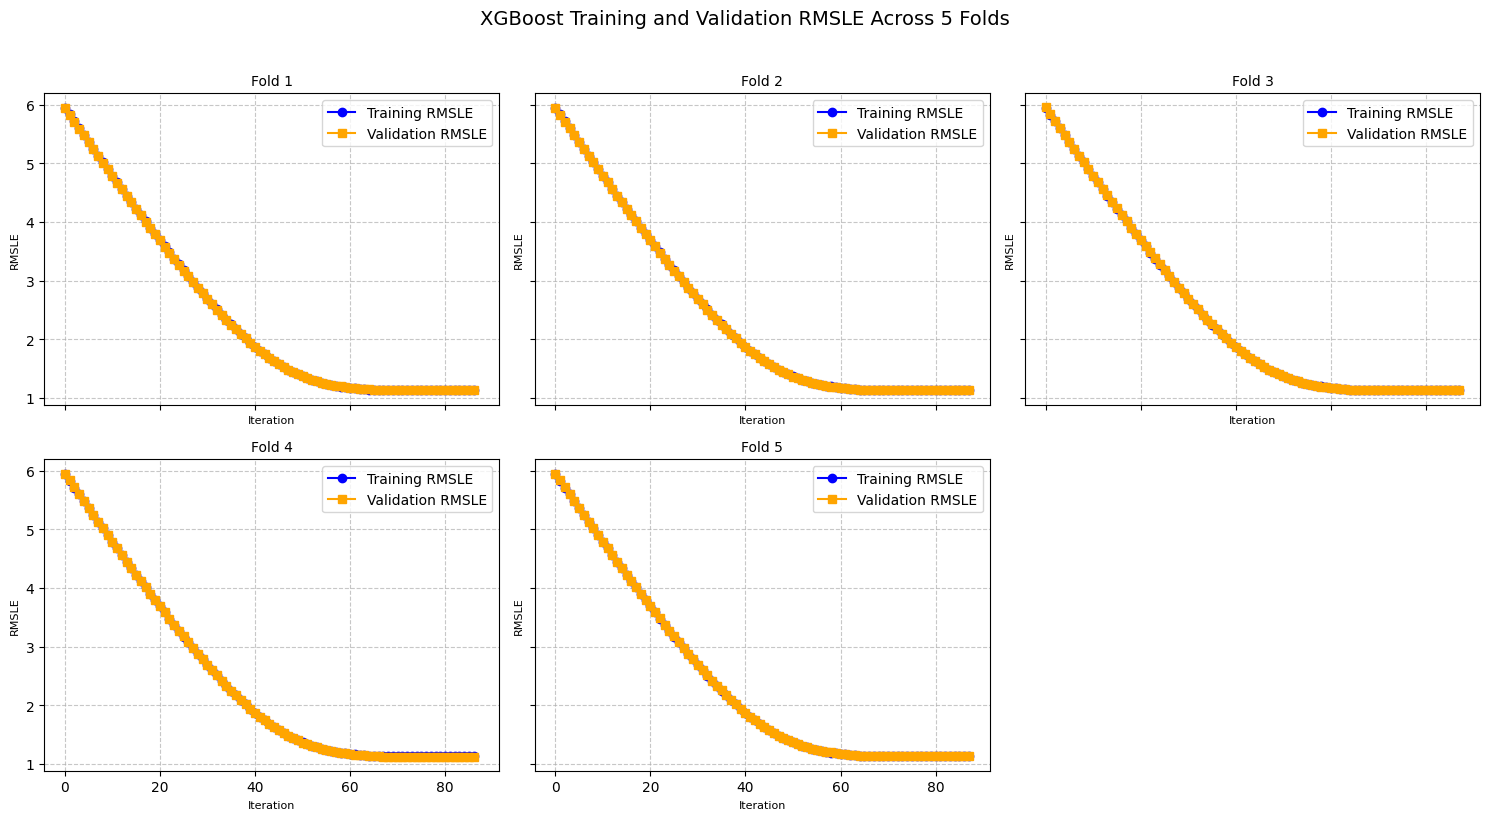

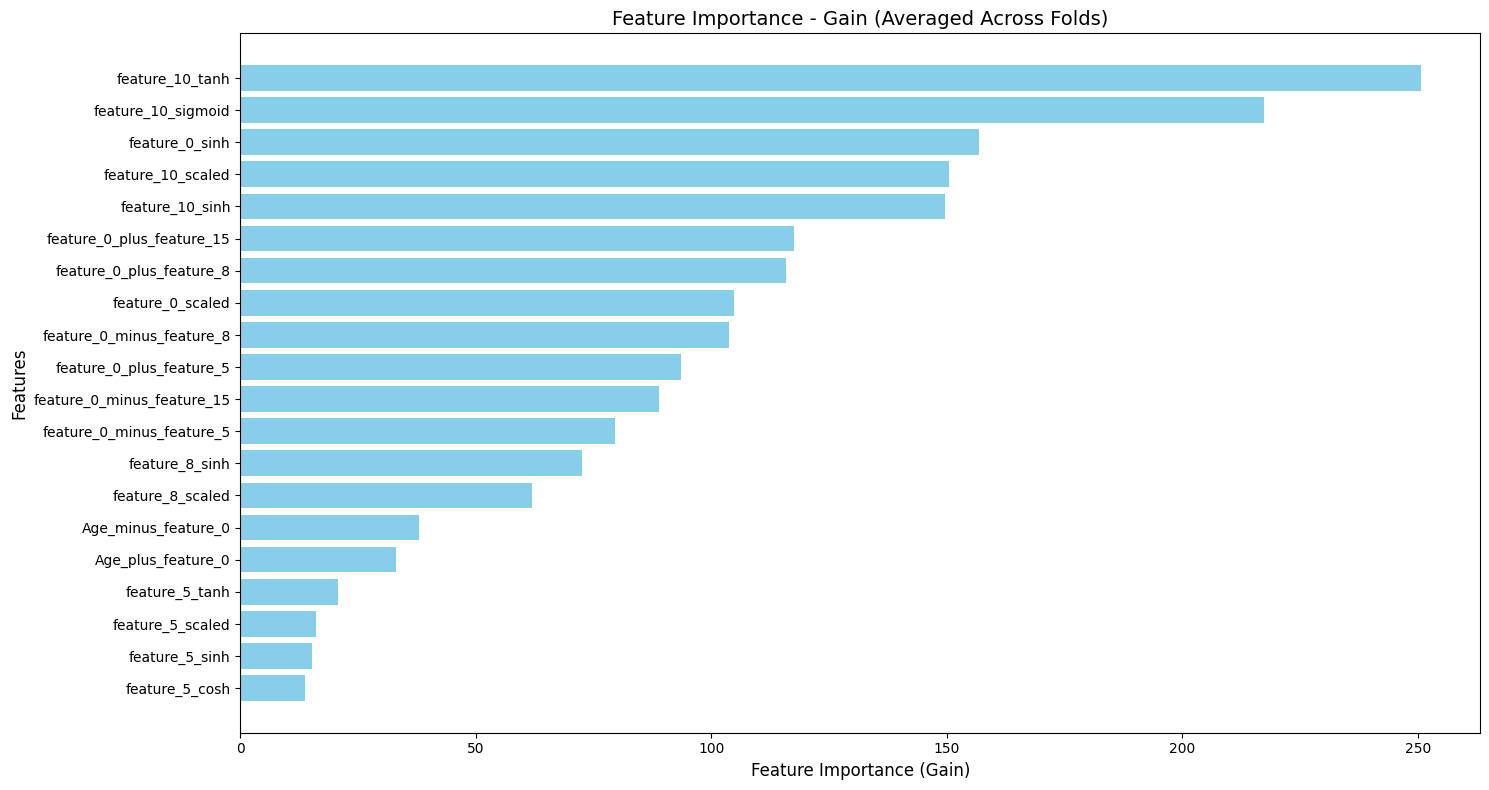


Feature Importance (Gain, Averaged Across Folds):
feature_10_tanh: 250.6375
feature_10_sigmoid: 217.2188
feature_0_sinh: 156.7000
feature_10_scaled: 150.5185
feature_10_sinh: 149.6312
feature_0_plus_feature_15: 117.6250
feature_0_plus_feature_8: 115.9375
feature_0_scaled: 104.7051
feature_0_minus_feature_8: 103.7012
feature_0_plus_feature_5: 93.5000
feature_0_minus_feature_15: 88.8125
feature_0_minus_feature_5: 79.4583
feature_8_sinh: 72.4630
feature_8_scaled: 61.8319
Age_minus_feature_0: 37.8333
Age_plus_feature_0: 33.0417
feature_5_tanh: 20.6250
feature_5_scaled: 16.0367
feature_5_sinh: 15.1719
feature_5_cosh: 13.7354


In [63]:
# Evaluate on all features with feature importance
result_original, eval_logs_original, feature_importance = perform_cv_xgb(
    X_train_val_xgb,
    y_train_val_xgb,
    pipelineXGB,
    plot_results=True,
    title_prefix="XGBoost",
    collect_feature_importance=True  
)

<p style="font-size:40px; font-weight:bold;">XGBoost Hyperparameter Tuning</p>

**Hyperparameter Tuning**

To enhance the XGBoost model’s performance and address potential underfitting or overfitting, we conducted hyperparameter tuning using Bayesian optimization with `BayesSearchCV` from scikit-optimize. This approach efficiently explores the hyperparameter space to optimize the Root Mean Squared Logarithmic Error (RMSLE)

A search space covering 9 hyperparameters:
- `max_depth` (3 to 7) - controls the maximum depth of each tree
- `learning_rate` (0.05 to 0.5, log-uniform) - step size for gradient updates
- `n_estimators` (100 to 1500) - number of boosting rounds
- `min_child_weight` (1 to 20) - minimum sum of instance weights required for a split
- `subsample` (0.3 to 1.0) - fraction of samples used per tree
- `colsample_bytree` (0.3 to 1.0) - fraction of features used per tree
- `reg_alpha` (0.0 to 10.0) - L1 regularization strength
- `reg_lambda` (0.0 to 10.0) - L2 regularization strength
- `gamma` (0.0 to 5.0) - minimum loss reduction required for a split


Bayesian Optimization setup:
- `n_iter=5` - runs 5 trials to explore the search space efficiently
- `cv=KFold(n_splits=3, shuffle=True, random_state=42)` - uses 3-fold cross-validation with shuffling for robust evaluation
- `scoring='neg_rmsle_scorer'` - custom scorer based on RMSLE (negative for minimization)
- `refit=True` - refits the best model using the RMSLE metric
- `n_jobs=1` - single-threaded execution to avoid resource conflicts
- `verbose=2` - provides detailed logging of the optimization process

In [64]:
neg_rmsle_scorer = make_scorer(rmsle_scorer, greater_is_better=False)
param_space = {
    'regressor__max_depth': Integer(3, 7),
    'regressor__learning_rate': Real(0.05, 0.5, prior='log-uniform'),
    'regressor__n_estimators': Integer(100, 1500),
    'regressor__min_child_weight': Integer(1, 20),
    'regressor__subsample': Real(0.3, 1.0),
    'regressor__colsample_bytree': Real(0.3, 1.0),
    'regressor__reg_alpha': Real(0.0, 10.0),
    'regressor__reg_lambda': Real(0.0, 10.0),
    'regressor__min_split_loss': Real(0.0, 5.0),
}

# Hyperparameter tuning
pipelineXGB.set_params(regressor__early_stopping_rounds=None)
opt = BayesSearchCV(
    estimator=pipelineXGB,
    search_spaces=param_space,
    n_iter=5,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    scoring=neg_rmsle_scorer,
    refit=True,
    n_jobs=1,
    random_state=42,
    verbose=2
)

opt.fit(X_train_val_xgb, y_train_val_xgb)
best_params = opt.best_params_
print("\nBest Parameters from skopt Bayesian Optimization:")
for param, value in best_params.items():
    print(f"{param}: {value}")

pipelineXGB.set_params(**best_params, regressor__early_stopping_rounds=20)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END regressor__colsample_bytree=0.5870727711973196, regressor__learning_rate=0.2671134443735555, regressor__max_depth=7, regressor__min_child_weight=7, regressor__min_split_loss=3.350739741344673, regressor__n_estimators=680, regressor__reg_alpha=3.5093133489914403, regressor__reg_lambda=7.3950423419042055, regressor__subsample=0.5131243177255543; total time=  31.5s
[CV] END regressor__colsample_bytree=0.5870727711973196, regressor__learning_rate=0.2671134443735555, regressor__max_depth=7, regressor__min_child_weight=7, regressor__min_split_loss=3.350739741344673, regressor__n_estimators=680, regressor__reg_alpha=3.5093133489914403, regressor__reg_lambda=7.3950423419042055, regressor__subsample=0.5131243177255543; total time=  31.2s
[CV] END regressor__colsample_bytree=0.5870727711973196, regressor__learning_rate=0.2671134443735555, regressor__max_depth=7, regressor__min_child_weight=7, regressor__min_split_loss=3.35073974

Pipeline(steps=[('regressor',
                 XGBRegressor(base_score=None, booster=None,
                              callbacks=[<__main__.EvalLogger object at 0x7ef6631d7490>],
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8596874091250211,
                              device='cuda', early_stopping_rounds=20,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.13708792117964527, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=15,
                              min_split_loss=4.5192603625334336, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1104, n_jobs=None,
                              num_parallel_tree=None, ...))])

Training fold 1/5...
[0]	validation_0-rmsle:5.96069	validation_1-rmsle:5.95674
[10]	validation_0-rmsle:4.89046	validation_1-rmsle:4.88675
[20]	validation_0-rmsle:3.87141	validation_1-rmsle:3.86808
[30]	validation_0-rmsle:2.93226	validation_1-rmsle:2.92956
[40]	validation_0-rmsle:2.13515	validation_1-rmsle:2.13351
[50]	validation_0-rmsle:1.59407	validation_1-rmsle:1.59398
[60]	validation_0-rmsle:1.52238	validation_1-rmsle:1.52262
[70]	validation_0-rmsle:1.52238	validation_1-rmsle:1.52262
[72]	validation_0-rmsle:1.52238	validation_1-rmsle:1.52262
Training fold 2/5...
[0]	validation_0-rmsle:5.96025	validation_1-rmsle:5.95853
[10]	validation_0-rmsle:4.89007	validation_1-rmsle:4.88831
[20]	validation_0-rmsle:3.87111	validation_1-rmsle:3.86928
[30]	validation_0-rmsle:2.93214	validation_1-rmsle:2.93023
[40]	validation_0-rmsle:2.13536	validation_1-rmsle:2.13335
[50]	validation_0-rmsle:1.59472	validation_1-rmsle:1.59265
[60]	validation_0-rmsle:1.52314	validation_1-rmsle:1.52107
[70]	validation_

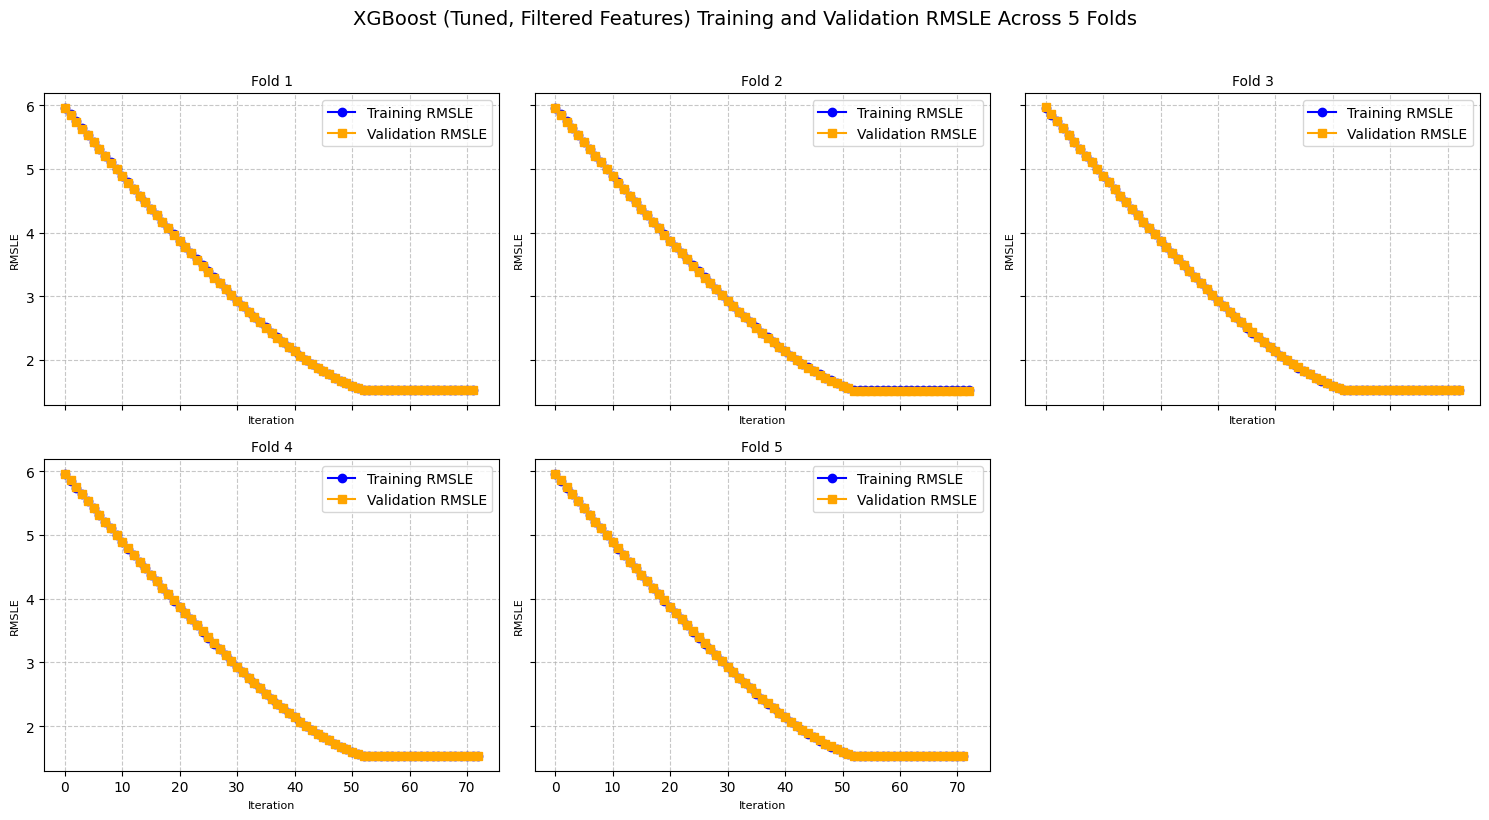

In [65]:
# Evaluate tuned model
tuned_result, tuned_eval_logs, _ = perform_cv_xgb(
    X_train_val_xgb,
    y_train_val_xgb,
    pipelineXGB,
    n_splits=5,
    random_state=42,
    plot_results=True,
    title_prefix="XGBoost (Tuned, Filtered Features)",
    collect_feature_importance=False
)

<p style="font-size:40px; font-weight:bold;">Performance Overview</p>

**XGBoost's Parameters**

<center>

| Parameters | Initial | Tuning |
| --- | --- | --- |
| `objective` | `reg:squaredlogerror` | `reg:squaredlogerror` |
| `learning_rate` | 0.15 | 0.137 |
| `gamma` | 2 | 4.519 |
| `max_depth` | 4 | 5 |
| `min_child_weight` | 3 | 15 |
| `n_estimators` | 1000 | 1104 |
| `subsample` | 0.8 | 0.5472 |
| `sampling_method` | `uniform` | `uniform` |
| `colsample_bytree` | 0.8 | 0.8597 |
| `reg_alpha` | 0.5 | 0.0 |
| `reg_lambda` | 2.0 | 6.5028 |
| `random_state` | 42 | 42 |
| `tree_method` | `hist` | `hist` |
| `early_stopping_rounds` | 20 | 20 |

</center>

**Performance Metrics**

<center>

| Model | Train RMSLE | Valid RMSLE |
| --- | --- | --- |
| Initial | 1.1256 ($\pm$ 0.0011) | 1.1256 ($\pm$ 0.0036) |
| Tuned | 1.5227 ($\pm$ 0.0006) | 1.5227   ($\pm$ 0.0021) |

</center>

**Comments**

- The **initial XGBoost model** achieves excellent performance with a Train RMSLE and a Valid RMSLE $\rightarrow$ no overfitting as the train and validation scores are identical
-  The low standard deviations demonstrate consistent performance across cross-validation folds, establishing a strong baseline
- The **tuned XGBoost model** underperforms compared to the initial model, with a higher Train RMSLE and Valid RMSLE. Moreover, the tighter standard deviations suggest stable results, but the elevated RMSLE indicates that the tuned hyperparameters may lead to underfitting or failure to capture the data’s patterns effectively

<p style='font-size:40px; font-weight:bold;'>CatBoost</p>

**Why choose CatBoost?**

CatBoost (Categorical Boosting) is a high-performance gradient boosting library designed for regression and classification tasks, particularly excelling with categorical features. Several aspects of the dataset and problem make it a compelling choice over a single Decision Tree

About the dataset:
- See `About the dataset` of Decision Tree

About the nature of the model:
- CatBoost provides **feature importance scores** based on prediction value change or loss function change, aiding model interpretation and debugging
- Unlike a single Decision Tree, CatBoost builds an ensemble of trees, with each tree correcting errors of the previous ones, leading to superior predictive performance
- CatBoost includes **regularization** and depth control to prevent overfitting, enhancing robustness
- CatBoost is optimized for speed, with GPU acceleration and efficient handling of categorical features

About the problem:
- CatBoost is well-suited for regression, predicting continuous outcomes by minimizing squared error loss.
- CatBoost serves as a strong baseline or complementary model to XGBoost, leveraging its unique handling of categorical features and robust performance.


**Architecture design**

**The initial hyperparameters setup**

- `loss_function='RMSLEObjective()'` (custom objective to minimize RMSLE)
- `eval_metric=RMSLEMetric()` (custom metric to evaluate RMSLE)
- `learning_rate=0.15` (controls the step size of gradient updates)
- `depth=4` (limits tree depth, equivalent to XGBoost's max_depth)
- `min_data_in_leaf=3` (requires a minimum number of samples in a leaf, similar to XGBoost's min_child_weight)
- `iterations=1000` (number of trees, equivalent to XGBoost's n_estimators)
- `subsample=0.8` (uses a fraction of data for each tree, equivalent to XGBoost's subsample)
- `colsample_bylevel=0.8` (uses a fraction of features per tree level, similar to XGBoost's colsample_bytree)
- `l2_leaf_reg=3.0` (L2 regularization on leaf weights, equivalent to XGBoost's reg_lambda)
- `random_strength=1.0` (controls randomness in tree construction)
- `bagging_temperature=1.0` (controls sampling intensity, adding stochasticity)
- `grow_policy='SymmetricTree'` (builds balanced trees, optimized for speed)
- `bootstrap_type='Bayesian'` (Bayesian bootstrapping for stochasticity)


**The hyperparameter tuning setup for Bayesian Optimization**

See in below

**Training setup**


1. **Data Split**:
   - Using a large train + validation set (85%) for cross-validation and tuning while a test set for final evaluation (15%) $\rightarrow$ kinda sufficient data for training on a complex feature set while holding out an unbiased test set

2. **Cross-Validation**:
   - 5-fold cross-validation with shuffling (`random_state=42`) for robust performance estimates and balancing bias-variance trade-off and ensures generalization

3. **Evaluation Metrics**:
   - Use **RMSLE** as the primary metric, computed using `mean_squared_log_error` from scikit-learn
   - Standard deviations (`+/- 2*std`) provide confidence intervals for cross-validation results

4. **Hyperparameter Tuning**:
   - Bayesian optimization planned to efficiently search for optimal hyperparameters minimizing RMSLE

5. **Training Proces**:

   - 


**Helper function**

In [66]:
# Custom RMSLE Objective
class RMSLEObjective:
    def calc_ders_range(self, approxes, targets, weights):
        targets = np.clip(targets, 0, None)
        approxes = np.clip(approxes, 0, None)
        errors = np.log1p(targets) - np.log1p(approxes)
        grad = -2.0 * errors / (1.0 + approxes + 1e-6)
        hess = 2.0 / ((1.0 + approxes + 1e-6) ** 2) + 2.0 * errors / ((1.0 + approxes + 1e-6) ** 2)
        hess = np.clip(hess, 1e-6, 1e6)
        if weights is not None:
            grad *= weights
            hess *= weights
        return list(zip(grad, hess))

# Custom RMSLE Metric
class RMSLEMetric:
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-6))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, targets, weights):
        approxes = np.array(approxes[0]) if isinstance(approxes, list) else np.array(approxes)
        targets = np.array(targets)
        approxes = np.clip(approxes, 0, None)
        targets = np.clip(targets, 0, None)
        errors = (np.log1p(targets) - np.log1p(approxes)) ** 2
        error_sum = np.sum(errors * (weights if weights is not None else 1.0))
        weight_sum = np.sum(weights) if weights is not None else len(targets)
        return error_sum, weight_sum

# EvalLogger class for CatBoost (RMSLE)
class EvalLogger:
    def __init__(self):
        self.train_rmsle = []
        self.valid_rmsle = []

    def log(self, evals_result):
        metric_key = None
        for key in evals_result.get('learn', {}).keys():
            if 'RMSLE' in key or 'Custom' in key:
                metric_key = key
                break
        if metric_key is None:
            raise KeyError("Custom RMSLE metric not found in evals_result")
            
        self.train_rmsle = evals_result['learn'][metric_key]
        self.valid_rmsle = evals_result['validation'][metric_key]

In [67]:
def perform_cv_cat(X, y, pipeline, n_splits=5, random_state=42, plot_results=True, 
                   title_prefix="CatBoost", collect_feature_importance=False):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_results = []
    eval_logs = []
    feature_importances = [] if collect_feature_importance else None

    # Identify categorical features
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        print(f"Training fold {fold + 1}/{n_splits}...")
        
        # Split data
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_valid_fold = X.iloc[valid_idx]
        y_valid_fold = y.iloc[valid_idx]

        # Clip targets to ensure non-negative
        y_train_fold = np.clip(y_train_fold, 0, None)
        y_valid_fold = np.clip(y_valid_fold, 0, None)

        # Instantiate logger
        eval_logger = EvalLogger()
        
        # Fit pipeline
        pipeline.fit(
            X_train_fold,
            y_train_fold,
            regressor__cat_features=cat_features,
            regressor__eval_set=[(X_valid_fold, y_valid_fold)],
            regressor__verbose=100,
            regressor__early_stopping_rounds=20
        )
        
        # Get evals_result from CatBoost
        model = pipeline.named_steps['regressor']
        evals_result = model.get_evals_result()
        eval_logger.log(evals_result)
        eval_logs.append(eval_logger)
        
        # Debug: Print logger contents
        print(f"Fold {fold + 1} - Train RMSLE log length: {len(eval_logger.train_rmsle)}")
        print(f"Fold {fold + 1} - Valid RMSLE log length: {len(eval_logger.valid_rmsle)}")
        
        # Collect feature importance if requested
        if collect_feature_importance:
            importance = model.get_feature_importance()
            feature_importance_dict = {feat: imp for feat, imp in zip(X.columns, importance)}
            feature_importances.append(feature_importance_dict)
        
        # Predict on training and validation sets
        y_pred_train_fold = pipeline.predict(X_train_fold)
        y_pred_valid_fold = pipeline.predict(X_valid_fold)
        
        # Calculate RMSLE on original scale
        y_train_fold = np.clip(y_train_fold, 0, None)
        y_pred_train_fold = np.clip(y_pred_train_fold, 0, None)
        y_valid_fold = np.clip(y_valid_fold, 0, None)
        y_pred_valid_fold = np.clip(y_pred_valid_fold, 0, None)
        train_rmsle = np.sqrt(mean_squared_log_error(y_train_fold, y_pred_train_fold))
        valid_rmsle = np.sqrt(mean_squared_log_error(y_valid_fold, y_pred_valid_fold))
        
        # Store results
        cv_results.append({
            'train_rmsle': train_rmsle,
            'valid_rmsle': valid_rmsle
        })

    # Aggregate results
    result = {
        'train_rmsle': np.mean([r['train_rmsle'] for r in cv_results]),
        'valid_rmsle': np.mean([r['valid_rmsle'] for r in cv_results]),
        'train_rmsle_std': np.std([r['train_rmsle'] for r in cv_results]) * 2,
        'valid_rmsle_std': np.std([r['valid_rmsle'] for r in cv_results]) * 2
    }

    # Print results
    print("\nCross-Validation Results:")
    print(f"  Train RMSLE: {result['train_rmsle']:.4f} (+/- {result['train_rmsle_std']:.4f})")
    print(f"  Valid RMSLE: {result['valid_rmsle']:.4f} (+/- {result['valid_rmsle_std']:.4f})")

    # Convert to DataFrame
    results_df = pd.DataFrame([result], index=['log_squared_error'])
    print("\nResults Summary (DataFrame):")
    print(results_df[['train_rmsle', 'valid_rmsle']])

    # Plot RMSLE curves (identical to XGBoost)
    if plot_results:
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True, sharey=True)
        axes = axes.flatten()
        for fold in range(n_splits):
            train_rmsle = eval_logs[fold].train_rmsle
            valid_rmsle = eval_logs[fold].valid_rmsle
            iterations = range(len(train_rmsle))
            ax = axes[fold]
            ax.plot(iterations, train_rmsle, label='Training RMSLE', marker='o', color='blue')
            ax.plot(iterations, valid_rmsle, label='Validation RMSLE', marker='s', color='orange')
            ax.set_title(f'Fold {fold + 1}', fontsize=10)
            ax.set_xlabel('Iteration', fontsize=8)
            ax.set_ylabel('RMSLE', fontsize=8)
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)
        fig.delaxes(axes[-1])
        plt.suptitle(f'{title_prefix} Training and Validation RMSLE Across {n_splits} Folds', fontsize=14, y=1.02)
        plt.tight_layout()
        print("Displaying RMSLE plot...")
        plt.show()

    if collect_feature_importance:
        aggregated_importance = {}
        for importance in feature_importances:
            for feat, gain in importance.items():
                if feat not in aggregated_importance:
                    aggregated_importance[feat] = []
                aggregated_importance[feat].append(gain)
        # Filter out features with zero mean importance
        feature_importance = [(feat, np.mean(gains)) for feat, gains in aggregated_importance.items() if np.mean(gains) >= 1]
        feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
        if feature_importance:  # Only plot/print if there are non-zero features
            plt.figure(figsize=(15, max(8, len(feature_importance) * 0.2)))
            features, importance_values = zip(*feature_importance)
            plt.barh(features, importance_values, color='skyblue')
            plt.xlabel('Feature Importance (Prediction Value Change)', fontsize=12)
            plt.ylabel('Features', fontsize=12)
            plt.title('Feature Importance - Prediction Value Change (Averaged Across Folds)', fontsize=14)
            plt.gca().invert_yaxis()
            plt.tight_layout()
            print("Displaying feature importance plot...")
            plt.show()
            print("\nFeature Importance (Prediction Value Change, Averaged Across Folds):")
            for feature, importance in feature_importance:
                print(f"{feature}: {importance:.4f}")
        else:
            print("\nNo features with non-zero importance.")
            feature_importance = None
    else:
        feature_importance = None

    return result, eval_logs, feature_importance

**Split the dataset**

Train the model with the non-transformation (normalization/scaling/standardization) traning dataset

Split the data into train + validation (85%) and test (15%)

In [69]:
# Preprocess data
train_cat = create_features(train, is_train=True, scaler=scaler, kmeans=kmeans)
train_cat['target'] = train['target']
test_cat = create_features(test, is_train=False, scaler=scaler, kmeans=kmeans)

# Separate features and target
X_cat = train_cat.drop('target', axis=1)
y_cat = train_cat['target']

# Train-Validation-Test split
X_train_val_cat, X_test_cat, y_train_val_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.15, random_state=42
)

print(f"Training set size: {X_train_val_cat.shape[0]} samples")
print(f"Test set size: {X_test_cat.shape[0]} samples")

Training set size: 1019999 samples
Test set size: 180000 samples


In [70]:
# Define pipeline
pipelineCatBoost = Pipeline(steps=[
    ('regressor', CatBoostRegressor(
        loss_function=RMSLEObjective(),
        eval_metric=RMSLEMetric(),
        iterations=1000,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5.0,
        bagging_temperature=1.0,
        random_strength=1.0,
        bootstrap_type='Bayesian',
        min_data_in_leaf=5,
        grow_policy='SymmetricTree',
        task_type='CPU',
        random_seed=42,
        early_stopping_rounds=20,
        verbose=100,
        use_best_model=True
    ))
])

Training fold 1/5...
0:	learn: 6.6602475	test: 6.6561745	best: 6.6561745 (0)	total: 2.89s	remaining: 48m 7s
100:	learn: 4.2251426	test: 4.2216806	best: 4.2216806 (100)	total: 49.7s	remaining: 7m 22s
200:	learn: 2.3090948	test: 2.3071882	best: 2.3071882 (200)	total: 1m 33s	remaining: 6m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.738065411
bestIteration = 263

Shrink model to first 264 iterations.
Fold 1 - Train RMSLE log length: 284
Fold 1 - Valid RMSLE log length: 284
Training fold 2/5...
0:	learn: 6.6597729	test: 6.6580751	best: 6.6580751 (0)	total: 1.19s	remaining: 19m 45s
100:	learn: 4.2279911	test: 4.2262188	best: 4.2262188 (100)	total: 48.1s	remaining: 7m 7s
200:	learn: 2.2479725	test: 2.2450129	best: 2.2450129 (200)	total: 1m 31s	remaining: 6m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.832766199
bestIteration = 227

Shrink model to first 228 iterations.
Fold 2 - Train RMSLE log length: 248
Fold 2 - Valid RMSLE log length: 2

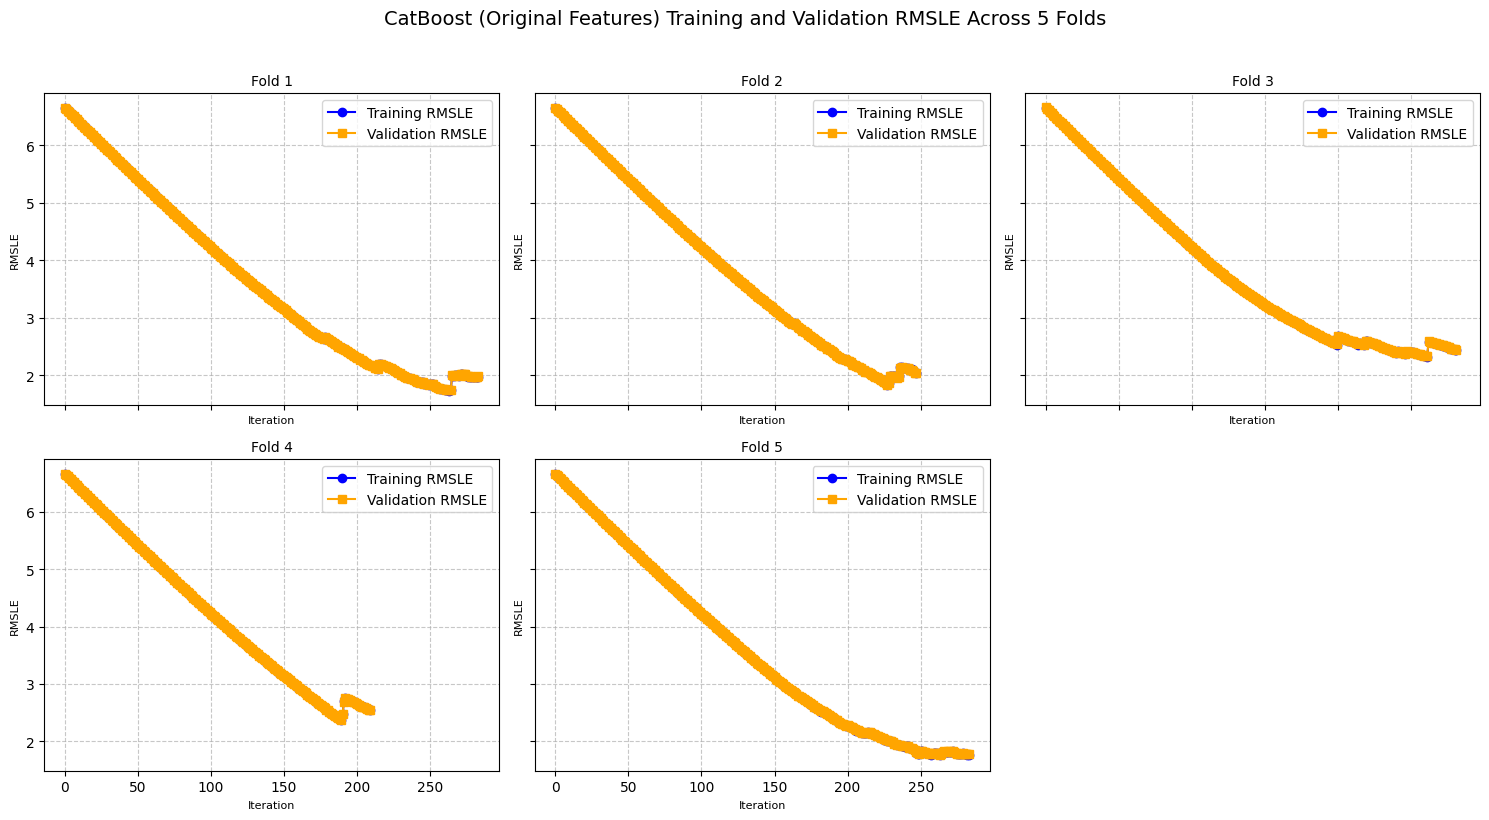

Displaying feature importance plot...


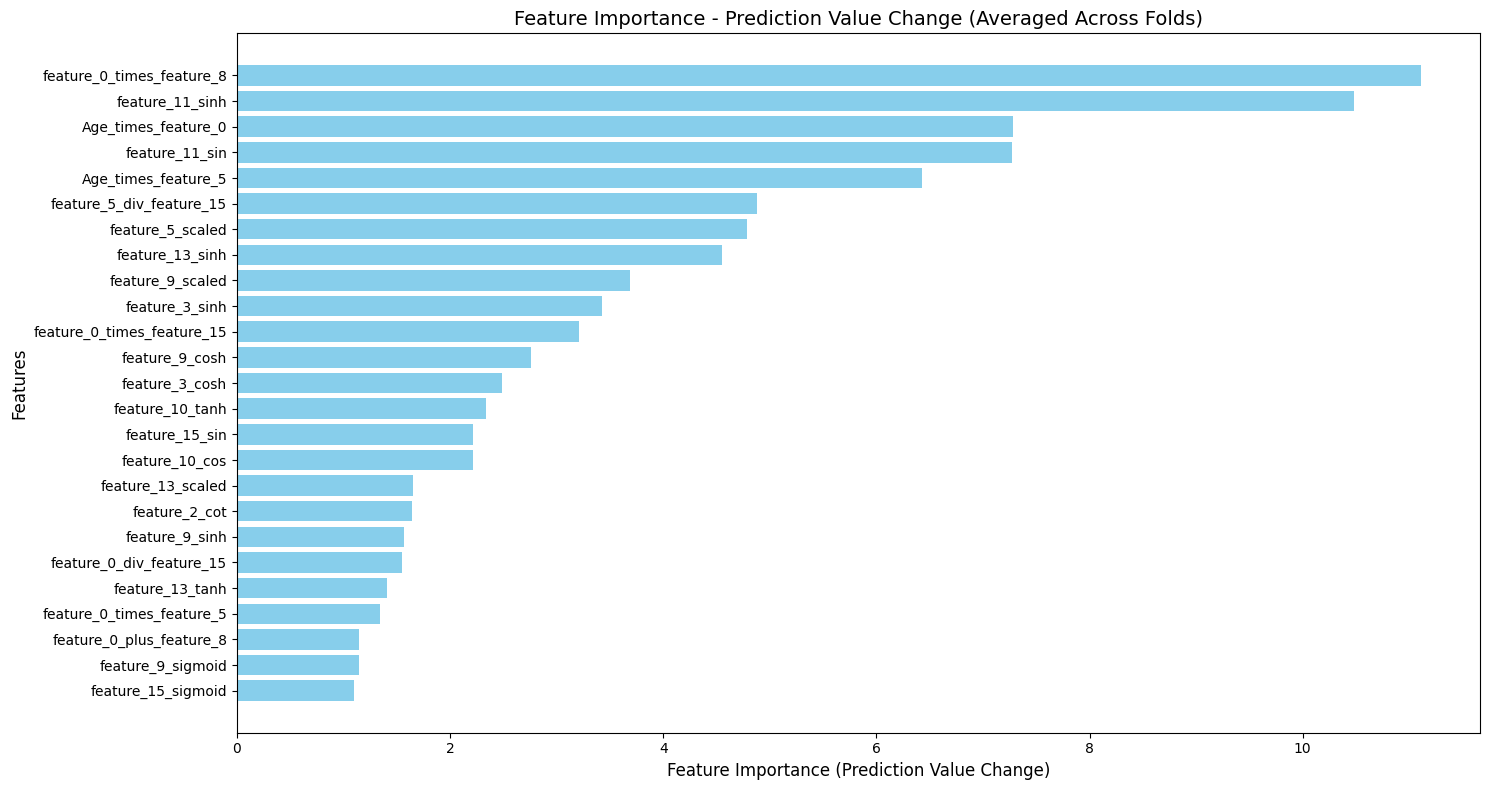


Feature Importance (Prediction Value Change, Averaged Across Folds):
feature_0_times_feature_8: 11.1086
feature_11_sinh: 10.4805
Age_times_feature_0: 7.2790
feature_11_sin: 7.2736
Age_times_feature_5: 6.4284
feature_5_div_feature_15: 4.8793
feature_5_scaled: 4.7832
feature_13_sinh: 4.5538
feature_9_scaled: 3.6855
feature_3_sinh: 3.4241
feature_0_times_feature_15: 3.2139
feature_9_cosh: 2.7592
feature_3_cosh: 2.4860
feature_10_tanh: 2.3345
feature_15_sin: 2.2175
feature_10_cos: 2.2159
feature_13_scaled: 1.6485
feature_2_cot: 1.6383
feature_9_sinh: 1.5684
feature_0_div_feature_15: 1.5520
feature_13_tanh: 1.4090
feature_0_times_feature_5: 1.3422
feature_0_plus_feature_8: 1.1437
feature_9_sigmoid: 1.1423
feature_15_sigmoid: 1.0962


In [71]:
result_original_cat, eval_logs_original_cat, feature_importance_cat = perform_cv_cat(
    X_train_val_cat,
    y_train_val_cat,
    pipelineCatBoost,
    plot_results=True,
    title_prefix="CatBoost (Original Features)",
    collect_feature_importance=True
)

<p style="font-size:40px; font-weight:bold;">CatBoost Hyperparameter Tuning</p>

**Hyperparameter Tuning**

To enhance the CatBoost model’s performance and address potential underfitting or overfitting, we conducted hyperparameter tuning using Bayesian optimization with `BayesSearchCV` from scikit-optimize. This approach efficiently explores the hyperparameter space to optimize the Root Mean Squared Logarithmic Error (RMSLE)

A search space covering 8 hyperparameters:
- `iterations` (100 to 1500) - number of boosting rounds
- `learning_rate` (0.001 to 0.5, log-uniform) - step size for gradient updates
- `depth` (3 to 12) - tree depth
- `min_data_in_leaf` (1 to 20) - minimum number of samples in a leaf
- `l2_leaf_reg` (0.0 to 10.0) - L2 regularization strength
- `bagging_temperature` (0.0 to 2.0) - intensity of Bayesian bootstrap
- `random_strength` (0.0 to 10.0) - randomness in split selection
- `border_count` (32 to 254) - number of splits for numerical features

Bayesian Optimization setup:
- `n_iter=5` - runs 5 trials to explore the search space efficiently
- `cv=KFold(n_splits=3, shuffle=True, random_state=42)` - uses 3-fold cross-validation with shuffling for robust evaluation
- `scoring='neg_rmsle_scorer'` - custom scorer based on RMSLE (negative for minimization)
- `refit=True` - refits the best model using the RMSLE metric
- `n_jobs=1` - single-threaded execution to avoid resource conflicts
- `verbose=2` - provides detailed logging of the optimization process

In [72]:
# Reinitialize pipeline for tuning
pipelineCatBoost = Pipeline(steps=[
    ('regressor', CatBoostRegressor(
        loss_function=RMSLEObjective(),
        eval_metric=RMSLEMetric(),
        iterations=1000,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5.0,
        bagging_temperature=1.0,
        random_strength=1.0,
        bootstrap_type='Bayesian',
        min_data_in_leaf=5,
        grow_policy='SymmetricTree',
        task_type='CPU',
        random_seed=42,
        early_stopping_rounds=20,
        verbose=100,
        use_best_model=False
    ))
])

neg_rmsle_scorer = make_scorer(rmsle_scorer, greater_is_better=False)
param_space = {
    'regressor__iterations': Integer(100, 1500),
    'regressor__learning_rate': Real(0.001, 0.5, prior='log-uniform'),
    'regressor__depth': Integer(3, 12),
    'regressor__l2_leaf_reg': Real(0.0, 10.0),
    'regressor__min_data_in_leaf': Integer(1, 20),
    'regressor__bagging_temperature': Real(0.0, 2.0),
    'regressor__random_strength': Real(0.0, 10.0),
    'regressor__border_count': Integer(32, 254)
}

# Set up Bayesian Optimization with BayesSearchCV
opt = BayesSearchCV(
    estimator=pipelineCatBoost,
    search_spaces=param_space,
    n_iter=5,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    scoring=neg_rmsle_scorer,
    refit=True,
    n_jobs=1,
    random_state=42,
    verbose=2
)

# Run optimization
opt.fit(X_train_val_cat, y_train_val_cat)

# Get and display the best parameters
best_params = opt.best_params_
print("\nBest Parameters from skopt Bayesian Optimization:")
for param, value in best_params.items():
    print(f"{param}: {value}")

pipelineCatBoost.set_params(
    **best_params,
    regressor__early_stopping_rounds=20,
    regressor__use_best_model=True
)

print("\nBest CV RMSLE:", -opt.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 6.6750306	total: 2.25s	remaining: 20m 20s
100:	learn: 5.5732496	total: 2m 11s	remaining: 9m 33s
200:	learn: 4.5405387	total: 4m 25s	remaining: 7m 29s
300:	learn: 4.0021371	total: 6m 37s	remaining: 5m 17s
400:	learn: 3.7975802	total: 8m 51s	remaining: 3m 6s
500:	learn: 3.6606047	total: 11m 5s	remaining: 54.5s
541:	learn: 3.6115042	total: 11m 59s	remaining: 0us
[CV] END regressor__bagging_temperature=0.8202079177066277, regressor__border_count=194, regressor__depth=11, regressor__iterations=542, regressor__l2_leaf_reg=6.701479482689346, regressor__learning_rate=0.013112749578222558, regressor__min_data_in_leaf=8, regressor__random_strength=7.3950423419042055; total time=12.0min
0:	learn: 6.6724965	total: 2.33s	remaining: 21m
100:	learn: 5.5708715	total: 2m 11s	remaining: 9m 34s
200:	learn: 4.5388729	total: 4m 25s	remaining: 7m 29s
300:	learn: 4.0343341	total: 6m 39s	remaining: 5m 19s
400:	learn: 3.8335363	total: 8m 57s	

Training fold 1/5...
0:	learn: 6.6843555	test: 6.6802789	best: 6.6802789 (0)	total: 1.23s	remaining: 29m 15s
100:	learn: 6.5584545	test: 6.5543965	best: 6.5543965 (100)	total: 48.3s	remaining: 10m 36s
200:	learn: 6.4329522	test: 6.4289134	best: 6.4289134 (200)	total: 1m 35s	remaining: 9m 45s
300:	learn: 6.3078638	test: 6.3038453	best: 6.3038453 (300)	total: 2m 22s	remaining: 8m 54s
400:	learn: 6.1832024	test: 6.1792048	best: 6.1792048 (400)	total: 3m 8s	remaining: 8m 5s
500:	learn: 6.0589834	test: 6.0550077	best: 6.0550077 (500)	total: 3m 55s	remaining: 7m 17s
600:	learn: 5.9352226	test: 5.9312699	best: 5.9312699 (600)	total: 4m 42s	remaining: 6m 30s
700:	learn: 5.8119336	test: 5.8080005	best: 5.8080005 (700)	total: 5m 28s	remaining: 5m 42s
800:	learn: 5.6891363	test: 5.6852289	best: 5.6852289 (800)	total: 6m 16s	remaining: 4m 56s
900:	learn: 5.5668478	test: 5.5629668	best: 5.5629668 (900)	total: 7m 3s	remaining: 4m 9s
1000:	learn: 5.4450832	test: 5.4412283	best: 5.4412283 (1000)	total

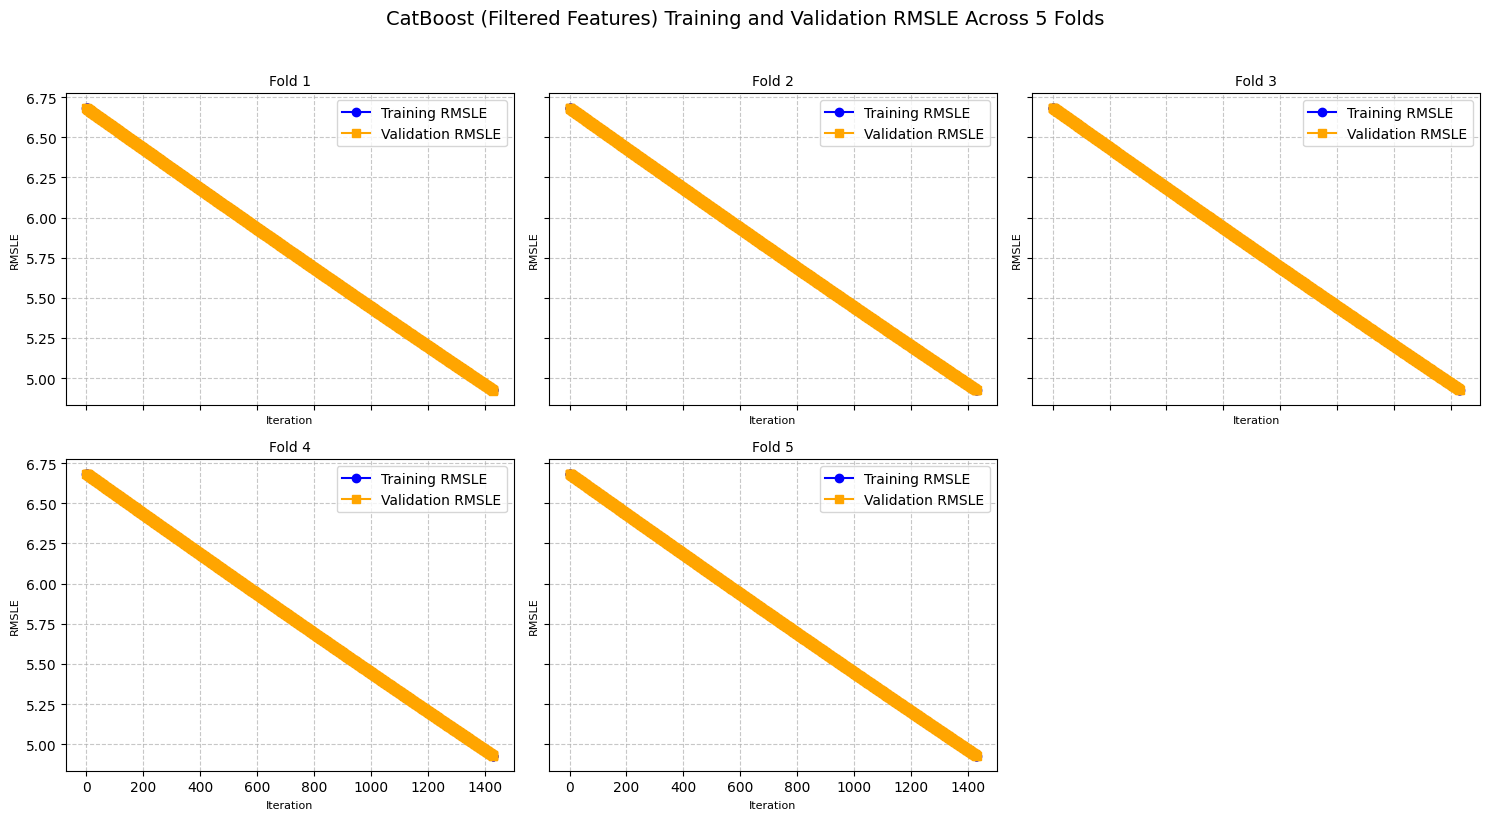

In [73]:
tuned_result_cat, tuned_eval_logs_cat, _ = perform_cv_cat(
    X_train_val_cat,
    y_train_val_cat,
    pipelineCatBoost,
    plot_results=True,
    title_prefix="CatBoost (Filtered Features)",
    collect_feature_importance=False
)

<p style="font-size:40px; font-weight:bold;">Performance Overview</p>

**CatBoost's Parameters**

<center>

| Parameters | Initial | Tuning |
| --- | --- | --- |
| `loss_function` | `RMSLEObjective()` | `RMSLEObjective()` |
| `eval_metric` | `RMSLEMetric()` | `RMSLEMetric()` |
| `iterations` | 1000 | 1432 |
| `learning_rate` | 0.03 | 0.0015 |
| `depth` | 6 | 6 |
| `l2_leaf_reg` | 5.0 | 8.6413 |
| `bagging_temperature` | 1.0 | 1.6748 |
| `random_strength` | 1.0 | 3.5359 |
| `min_data_in_leaf` | 5 | 4 |
| `border_count` | Not set | 228 |
| `bootstrap_type` | `Bayesian` | `Bayesian` |
| `grow_policy` | `SymmetricTree` | `SymmetricTree` |
| `task_type` | `CPU` | `CPU` |
| `random_seed` | 42 | 42 |
| `early_stopping_rounds` | 20 | 20 |
| `use_best_model` | `True` | `True` |

</center>

**Performance Metrics**

<center>

| Model | Train RMSLE | Valid RMSLE |
| --- | --- | --- |
| Initial | 2.0077 ($\pm$ 0.5594) | 2.0086 ($\pm$ 0.5609) |
| Tuned | 4.9261 ($\pm$ 0.0009) | 4.9261 ($\pm$ 0.0038) |

</center>

**Comments**

- The **initial CatBoost model** achieves reasonable performance with a Train and Valid RMSLE $\rightarrow$ minimal overfitting as the train and validation scores are nearly identical
- However, the high standard deviations suggest variability across cross-validation folds, potentially due to the model’s sensitivity to the dataset’s complexity or feature engineering
- The **tuned CatBoost model** significantly underperforms compared to the initial model
- The much tighter standard deviations indicate consistent but poor performance (underfitting)

In [ ]:
test_cat = test_cat[important_features]
n_test_rows = len(test_cat)

y_pred = pipelineCatBoost.predict(test_cat)

submission = pd.DataFrame({
    'id': range(1200000, 1200000 + n_test_rows),
    'target': y_pred
})


submission.to_csv('submission.csv', index=False)
print("submission.csv created successfully!")